# Bank Telemarketing Campaign - Predictive Modeling Project

**Project Goal:** Build data-driven models to predict the success of telemarketing calls for long-term bank deposits

**Dataset Period:** 2008-2013 (Global Financial Crisis)

**Methodology:** CRISP-DM (Cross-Industry Standard Process for Data Mining)

---

## 1. Business Understanding

### 1.1 Business Objectives
The project's goal is to create a model that will help banks more effectively conduct telemarketing campaigns aimed at selling long-term deposits. Currently, the bank relies on manual targeting strategies, which means calling many customers who are ultimately not interested in the offer. This approach leads to high operational costs and inefficient use of marketing resources. With the use of historical data and machine learning models, we aim to predict which customers are most likely to subscribe to a deposit. Such predictions will allow marketing managers to focus their efforts on the most promising clients, reducing unnecessary calls, and optimizing overall marketing performance. As a result it will lead to bigger profits.

### 1.2 Project Goals and Successs Criteria
From a data mining perspective, this problem is formulated as a binary classification task, where the target variable (y) indicates whether a client subscribed to the deposit (yes/no). The model will learn from historical customer, campaign, and macroeconomic data collected between 2008 and 2013, a period marked by significant financial fluctuations. This setting will provide a realistic, high-variance environment for training and evaluating predictive
models.

Because the dataset is imbalanced, the main performance measure will be the AUC-PR (Area Under the Precision–Recall Curve), which better reflects the model’s ability to correctly identify rare positive outcomes. More about it will be disscused in the next section of this report. Additional metrics such as precision, recall, F1-score, and AUC-ROC will also be tracked to provide a comprehensive understanding of model performance.

The success criteria for this project are as follows:

- Achieving a significant improvement over the baseline AUC-PR by the model, demonstrating its ability to identify rare positive cases more effectively than random guessing - AUC > 0.4
- Maintaing a good trade-off between precision and recall, ensuring that the model not only finds potential subscribers but also minimizes false positives. - Precision ≥ 0.35 and Recall ≥ 0.45
- Maintaining computational efficiency, i.e. finding an approach that can be used in real marketing operations. - Training time < 15 minutes per model on the full dataset
- Ensuring that the results are interpretable, providing insights into which customer or campaign factors influence the likelihood of subscription.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.combine import SMOTETomek, SMOTEENN
import time
from scipy.stats import randint
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, average_precision_score, classification_report, roc_auc_score, roc_curve


from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import math

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

---
## 2. Data Understanding

### 2.1 Data Collection

The first step is to load the dataset into the working environment. This involves importing the necessary libraries and reading the data file into a suitable data structure, namely, a DataFrame using Pandas.

In [3]:
# Load the dataset
df = pd.read_csv('bank.csv', sep=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### 2.2 Data Description

##### Basic dataset information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

This dataset contains 41188 entries and 21 features, representing information collected from a direct marketing campaign by a Portuguese bank institution. Each row corresponds to a contact with a client and the goal is to predict whether the client purchased the term deposit.

In [5]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### 2.3 Data Exploration

#### Target variable analysis

The target variable `y` represents whether a customer will buy a long-term bank deposit or not.
To check class imbalance we will compare the number of records with 'yes' and 'no' values in *y* column and plot a bar plot to depict class distribution.

In [7]:
# target value
goal = df['y']
counts = goal.value_counts()
percent = goal.value_counts(normalize=True)
percent100 = goal.value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
pd.DataFrame({'y': counts,'percent': percent100})

,y,percent
y,,
no,36548,88.7%
yes,4640,11.3%


  class  count   percent
0    no  36548  0.887346
1   yes   4640  0.112654


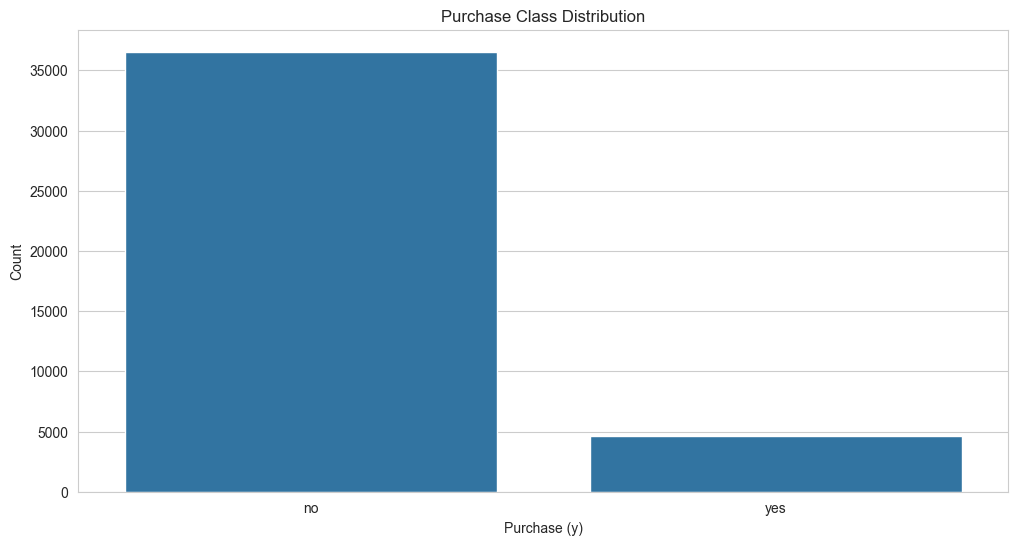

In [8]:
subscription_summary = pd.DataFrame({
    'class': counts.index,
    'count': counts.values,
    'percent': percent.values
})

print(subscription_summary)

sns.countplot(data=df, x='y')
plt.title('Purchase Class Distribution')
plt.xlabel('Purchase (y)')
plt.ylabel('Count')
plt.show()

As an additional check, we will calculate imbalance ratio.

In [9]:
imbalance_ratio = counts.min() / counts.max()
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

Imbalance ratio: 0.13


Imbalance ratio is 0.13 (below 0.2) which means there's a severe imbalance. Dataset is dominated by non-purchase cases.
Without adressing this imbalance, predictive models predicting "no purchase" would achieve high accuracy, but fail to identify potential buyers.

To handle class imbalance we will use SMOTE combined with Tomek Links technique later on in paragraph `3.4.4`.

#### Univariate analysis
In the next step, we will extract numerical and categorical features from the dataset for separate analysis.

In [10]:
numericFeatures = list(df.select_dtypes(include='number').columns)
categFeatures = list(set(df.columns) - set(numericFeatures))

# Remove goal attribute
goalAttrib = df.columns.values.tolist()[-1]
if goalAttrib in categFeatures:
    categFeatures.remove(goalAttrib)
elif goalAttrib in numericFeatures:
    numericFeatures.remove(goalAttrib)
    
print(len(numericFeatures)," Numeric Features: ",numericFeatures)
print(len(categFeatures)," Categorical Features: ",categFeatures)

10  Numeric Features:  ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
10  Categorical Features:  ['default', 'housing', 'marital', 'contact', 'education', 'loan', 'day_of_week', 'month', 'job', 'poutcome']


Numerical features: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

#### Feature distribution analysis

Now we will perform feature distribution analysis to examine how the data values are spread across the dataset. We will use plots and histograms to visualise the distributions of categorical and numerical features. Box plots for numerical features will be skipped in this step, as they will be specifically used for outlier detection in paragraph `2.4.2`.

In [11]:
def categ_feat_distribution():
    nrows = math.ceil(len(categFeatures) / 2)
    ncols = 2

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))

    axes = axes.flatten() if len(categFeatures) > 1 else [axes]

    for i, col in enumerate(categFeatures):
        df[col].value_counts().plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'{col} Counts')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')

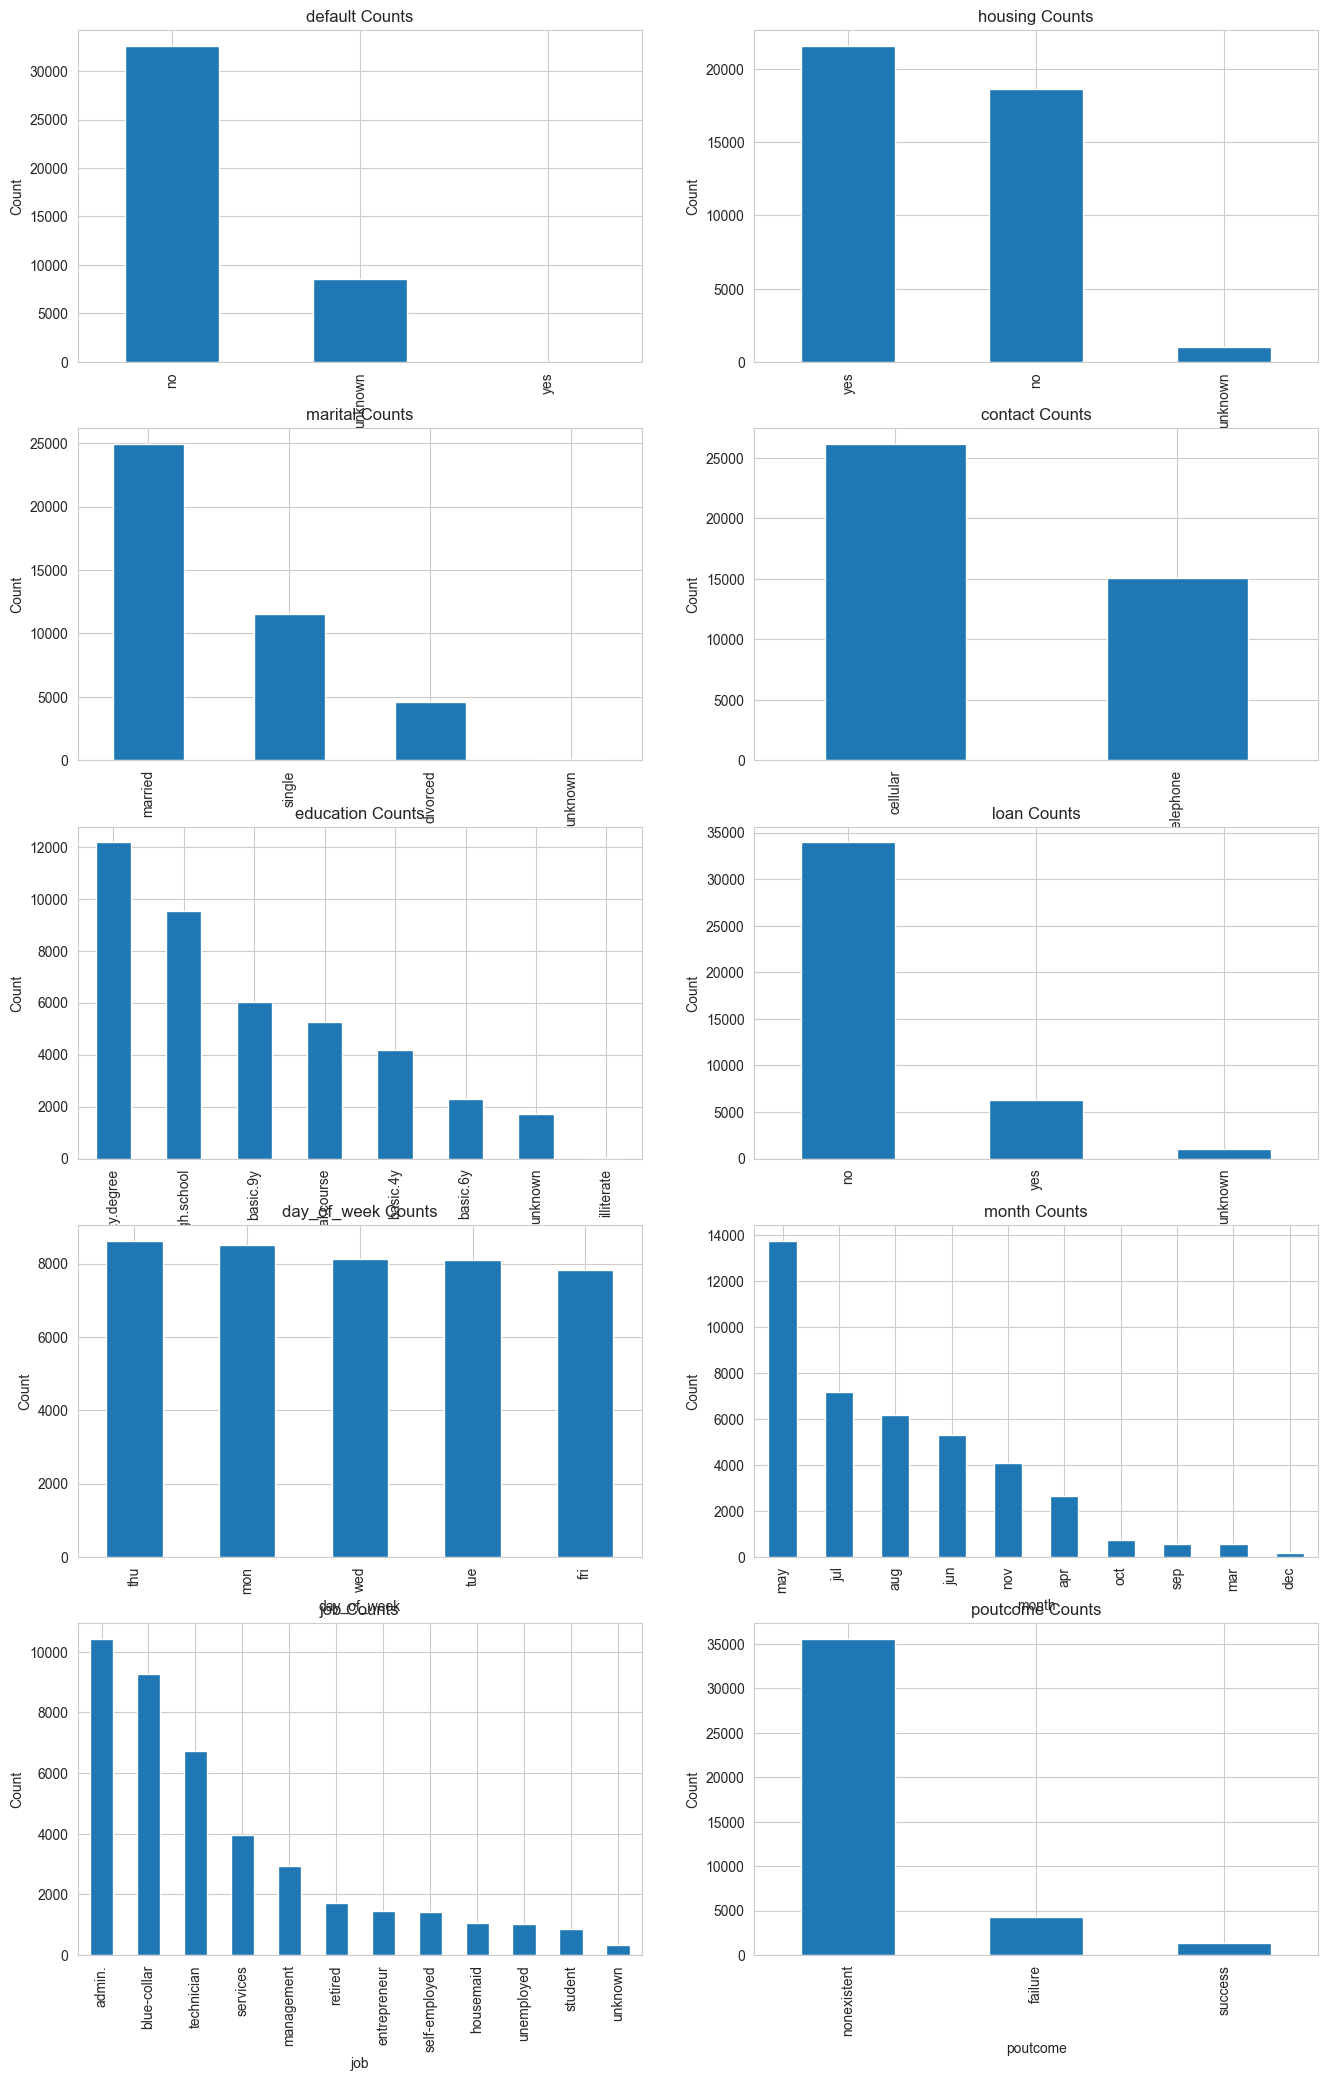

In [12]:
categ_feat_distribution()

There are 'unknown' values present in several catagorical features, which represent missing data, which, in turn, distorts statistical summaries. Because of this we will revisit and redo this analysis after `Data Cleaning` to ensure accuracy.

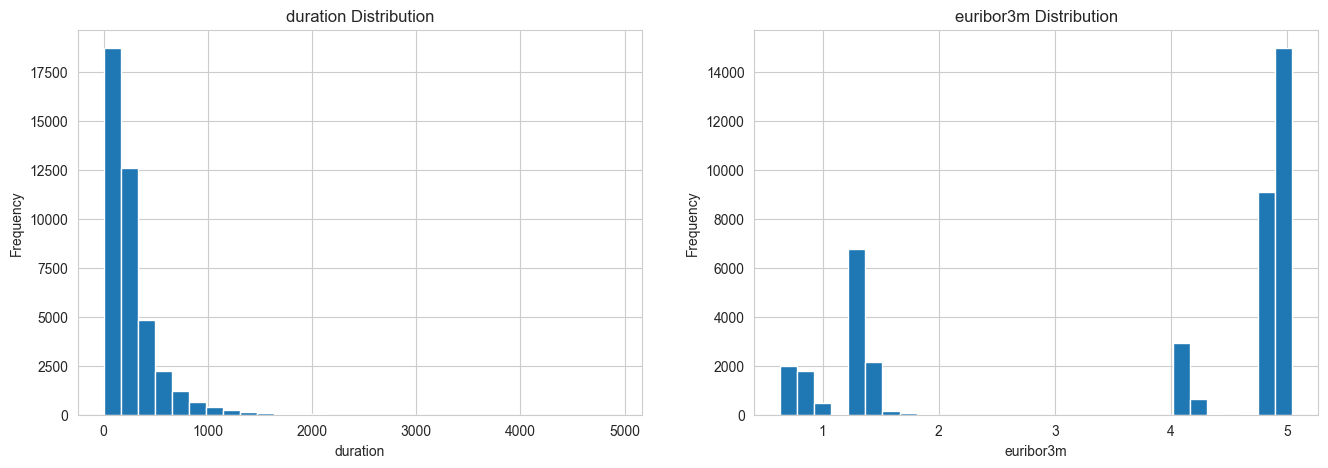

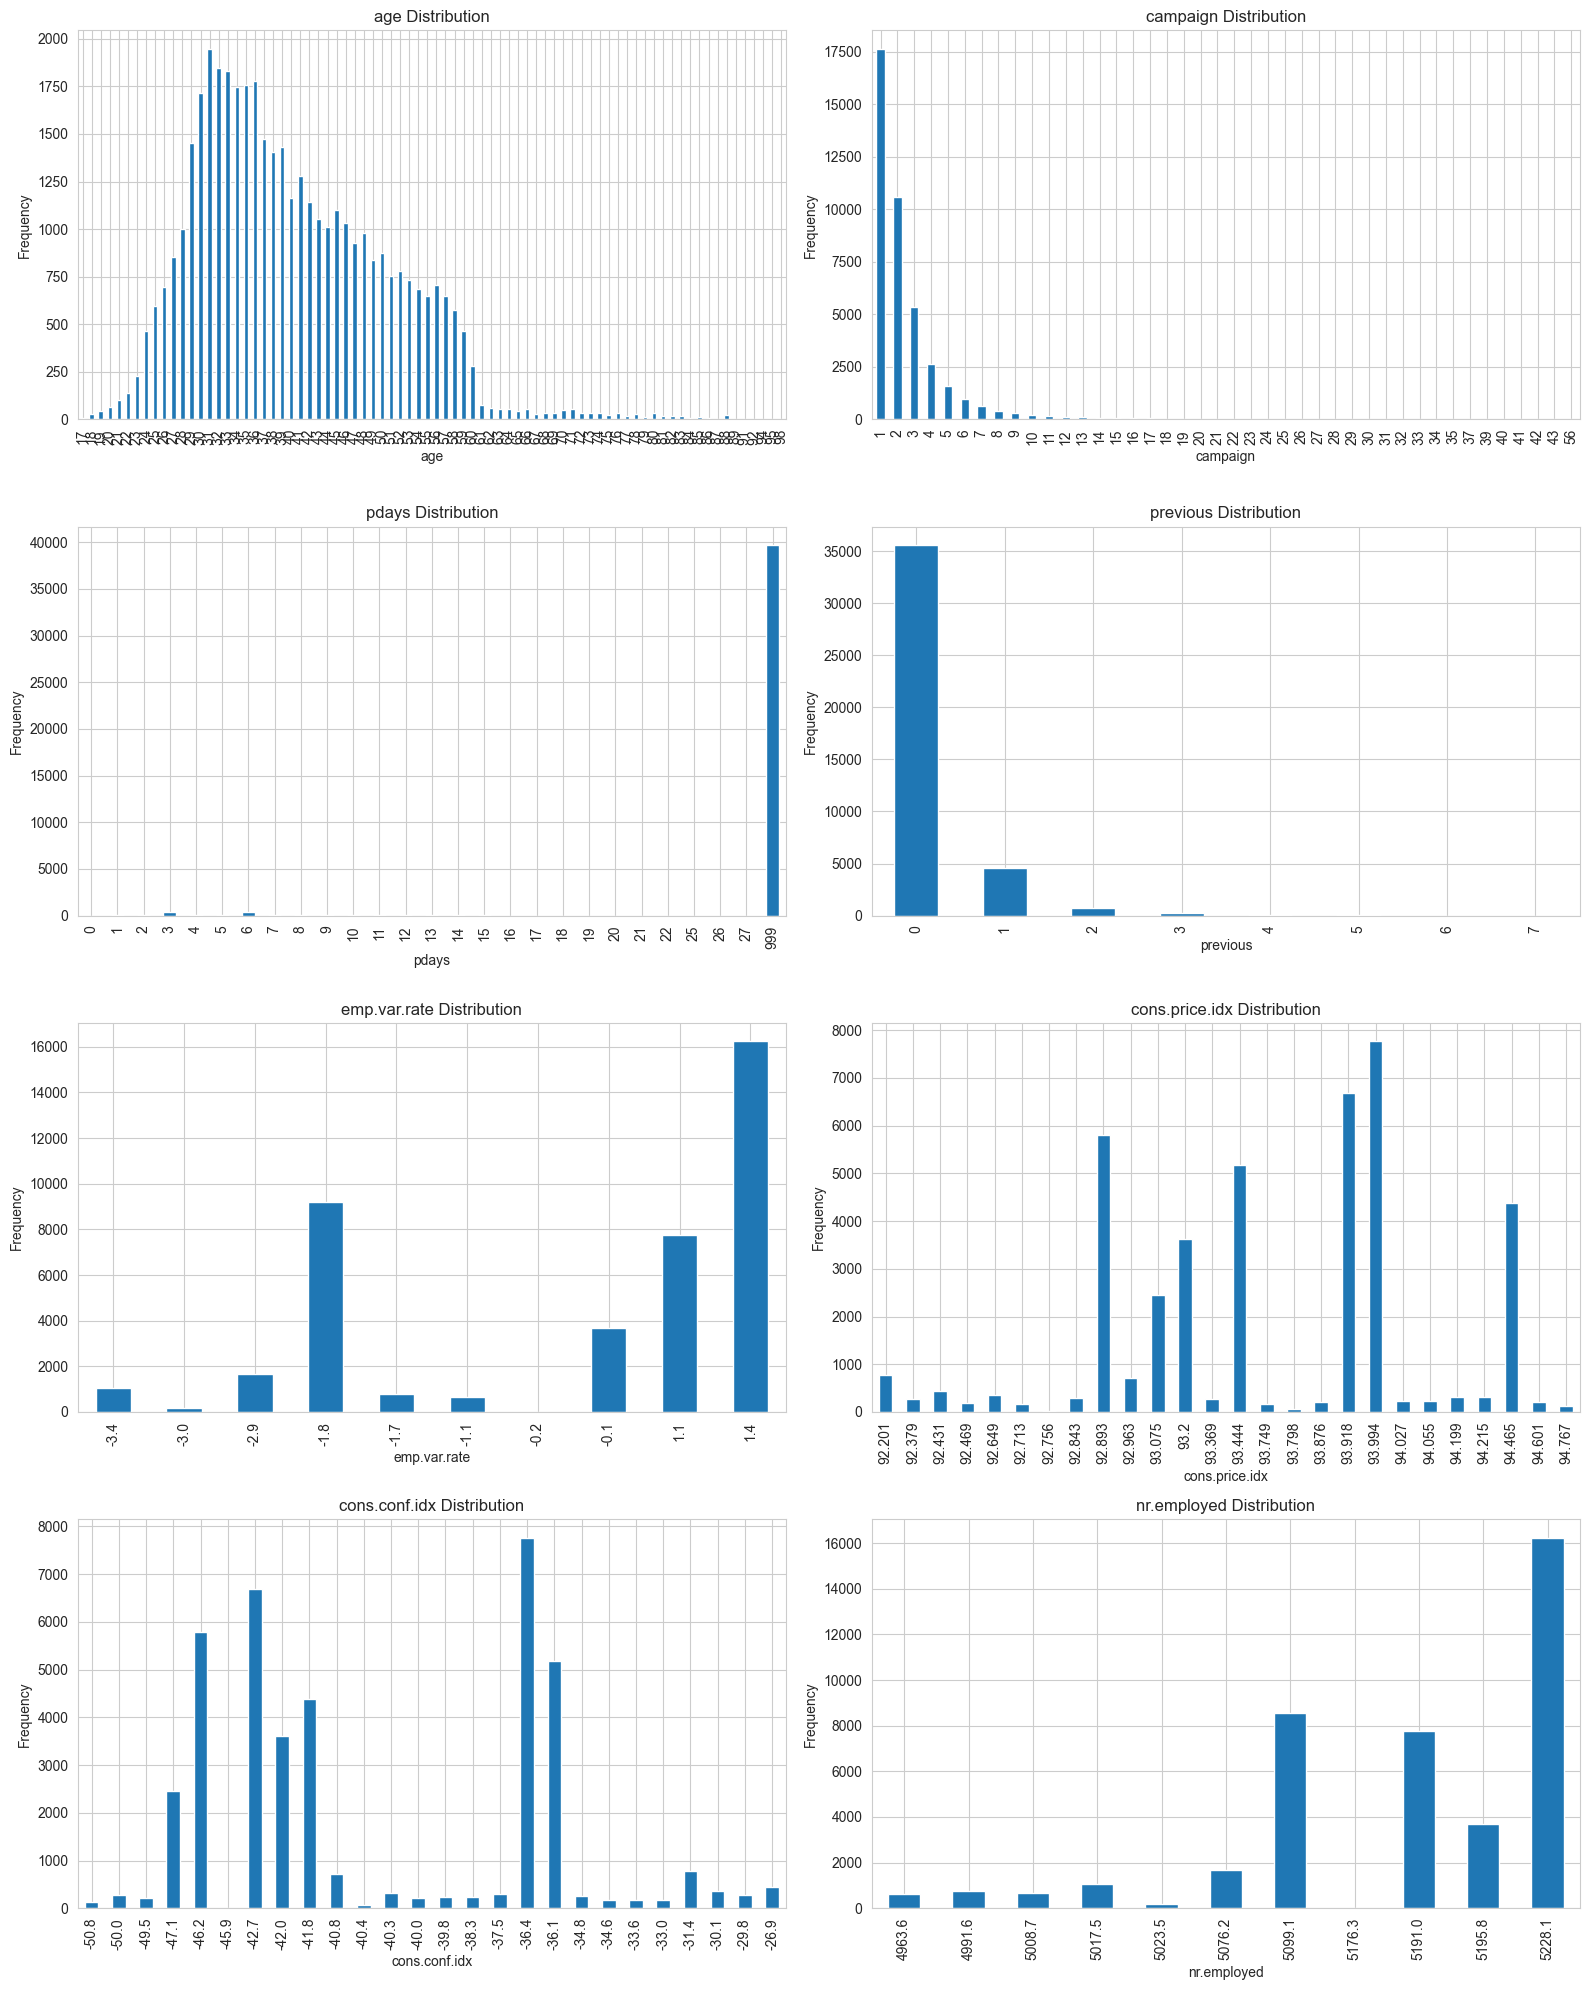

In [13]:
nonDiscreteFeatures = ['duration', 'euribor3m']
discreteFeatures = [f for f in numericFeatures if f not in nonDiscreteFeatures]

# histograms for continous featueres
nrows = math.ceil(len(nonDiscreteFeatures) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))
axes = axes.flatten()

for i, col in enumerate(nonDiscreteFeatures):
    df[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.show()

# bar plot for discrete features
nrows = math.ceil(len(discreteFeatures) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))
axes = axes.flatten()

for i, col in enumerate(discreteFeatures):
    counts = df[col].value_counts().sort_index()
    counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide unused axes
for j in range(len(discreteFeatures), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


None of the numerical features has normal distribution. Only *age* distribution is close to normal distribution. *duration*, *campaign* and *previous* are strongly skewed to the right, whereas *euribor3m* and *nr.employed* are very slightly skewed to the left. *emp.var.rare*, *cons.conf.idx* and it can be ignored.
Variablies with skewed distribution will be handled in paragraph `3.4.3` to avoid issues with distance-based models used in paragraph `4.2`.

*pdays* distribution is not accurate because of '999' value which indicates that the client hasn't been called before. There is a huge spike at 999, which inidicates that many clients are new targets for the campaign. Therefore, for more detailed interpretation, the analysis of this feature will be conducted again after `Data Cleaning`.

The data represented by other variables is highly variable with clusters at different value ranges and lots of fluctuations in frequency.

In [14]:
skewed_cols = ['duration', 'campaign', 'previous']

### 2.4 Data Quality Assessment

#### 2.4.1 Identify missing values

In the first place, we will check for missing values to ensure data completeness and avoid potential issues during analysis and modeling.

In [15]:
# % missing values by column

nulls = df.isnull().sum()
percent = round(nulls/df.shape[0]*100,3)
nullvalues = pd.concat([nulls,percent], axis=1, keys=('Cont','%'))
nullvalues
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Since there are no empty cells and 'unknown' value indicates a missing value, `df.isnull()` cannot be used. It will return information that there are no missing values, hence the cells with 'unknown' must be checked manually (and not using a pre-build function).

In [16]:
def check_unknown():
    categorical_cols_with_unknown = ['job', 'marital', 'education', 'default', 'housing', 'loan']
# Count 'unknown' in each column
    unknown_counts = {col: (df[col] == 'unknown').sum() for col in categorical_cols_with_unknown}
    unknown_df = pd.DataFrame.from_dict(unknown_counts, orient='index', columns=['Count'])
    unknown_df['Percent'] = round(unknown_df['Count'] / df.shape[0] * 100, 3)
    print(unknown_df)

In [17]:
check_unknown()

           Count  Percent
job          330    0.801
marital       80    0.194
education   1731    4.203
default     8597   20.873
housing      990    2.404
loan         990    2.404


Columns *job*, *marital*, *education*, *default*, *housing* and *loan*, as indicated in the `bank-information.txt` file, contain missing values labaled as 'unknown'. 

The frequency of 'unknown' entries varies across columns, with *default* having the highest proportion at 20.87% (8,597 entries), followed by *education* at 4.20% (1,731 entries), *housing* and *loan* both at 2.40% (990 entries each), *job* at 0.80% (330 entries), and *marital* at 0.19% (80 entries).

#### 2.4.2 Identify outliers

Based on dataframe information in `paragraph 2.2` there might be potential outliers such as clients contacted up to 56 times in the *capmaign* variable. It can disproportionately influence analysis and model results.
That's why now we will identify outliers.

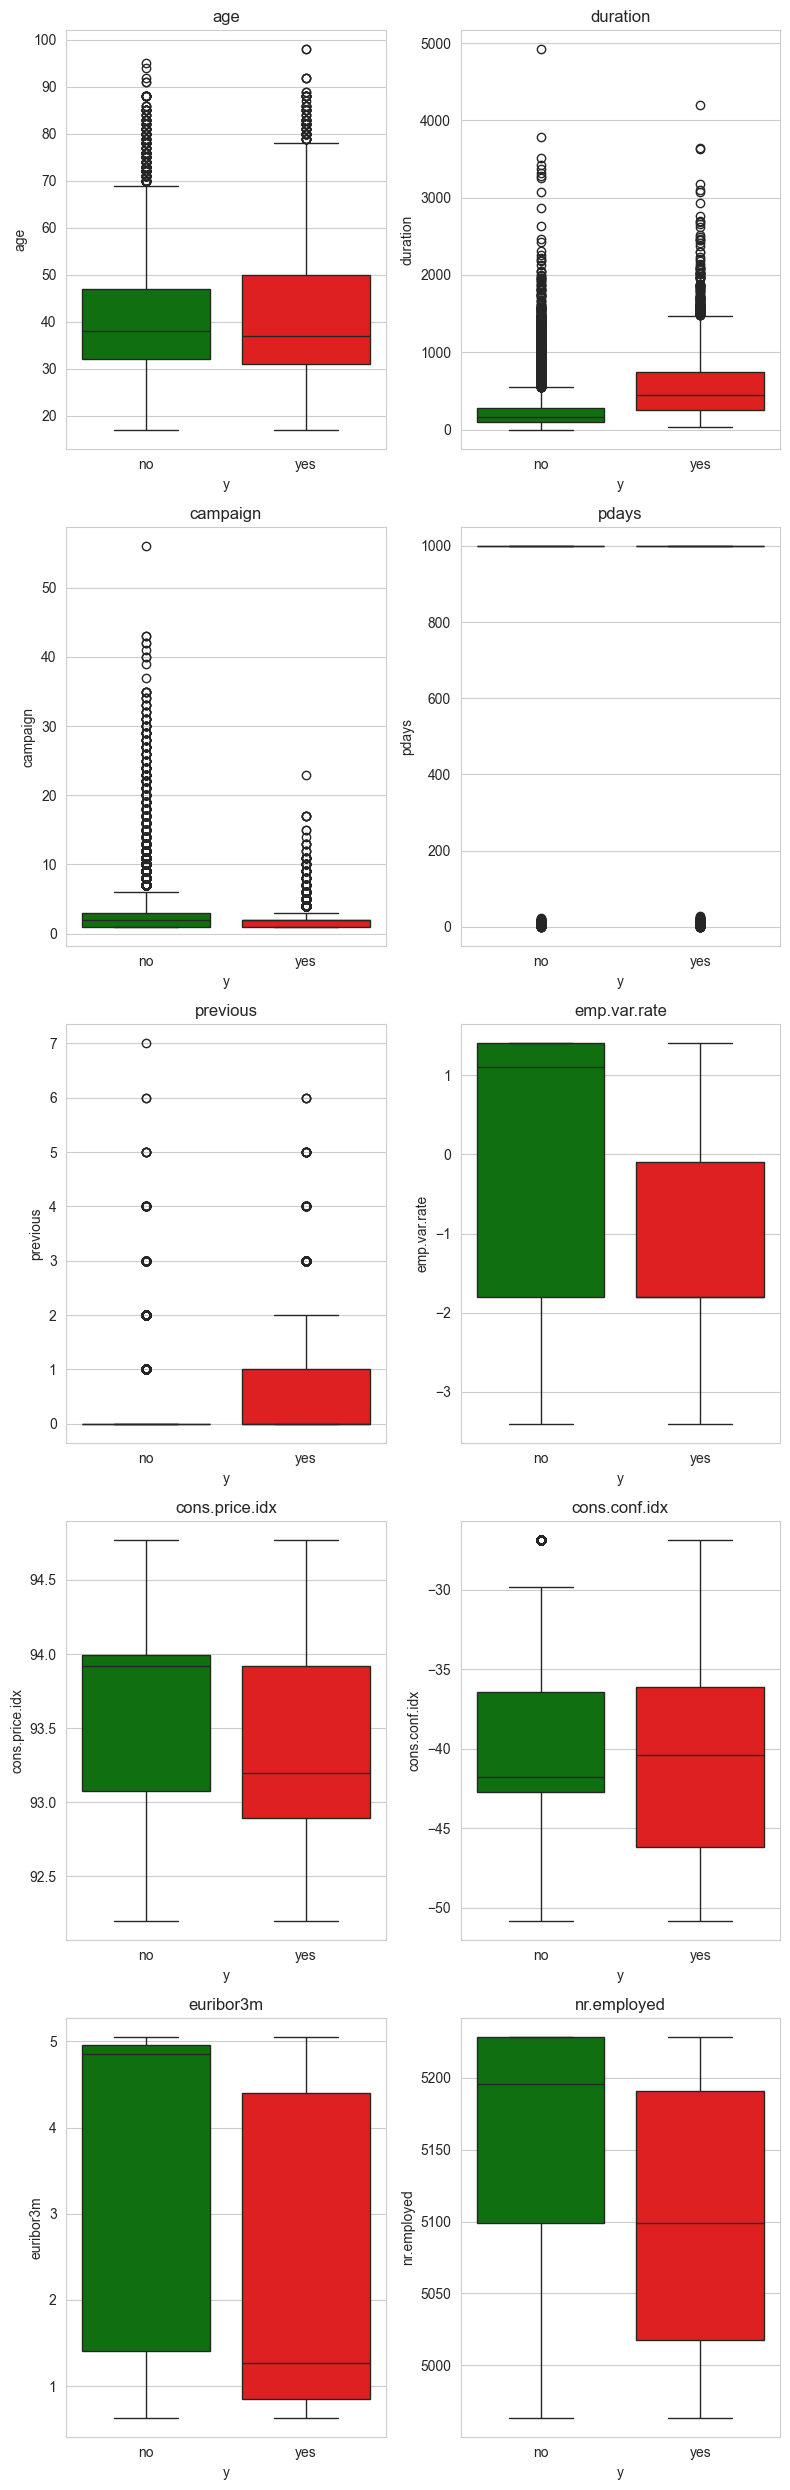

In [18]:
num_plots = len(numericFeatures)
cols = 2
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(cols * 4, rows * 5)) 

for i, feature in enumerate(numericFeatures):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(data=df, x='y', y=feature, hue='y', palette={"yes": "red", "no": "green"})
    plt.title(feature)

plt.tight_layout()
plt.show()


In [19]:
Q1 = df[numericFeatures].quantile(0.25)
Q3 = df[numericFeatures].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[numericFeatures] < (Q1 - 1.5 * IQR)) | (df[numericFeatures] > (Q3 + 1.5 * IQR)))
print("Number of outliers per numeric feature:")
print(outliers.sum())

outliers_cols = outliers.any()
outliers_cols = outliers_cols[outliers_cols].index.tolist()
print("\nColumns containing outliers:")
print(outliers_cols)

Number of outliers per numeric feature:
age                469
duration          2963
campaign          2406
pdays             1515
previous          5625
emp.var.rate         0
cons.price.idx       0
cons.conf.idx      447
euribor3m            0
nr.employed          0
dtype: int64

Columns containing outliers:
['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.conf.idx']


We performed outliers detection on all numerical features using the Interquartile Range (IQR) method and visualized it using boxplots.

Features such as *previous*, *duration* and *campaign* contained a high number of outlier values.
*age* and *pdays* alco contained a noticeable number out outliers.
Several features, including *emp.var.rate*, *cons.price.idx*, *e8uribor3m* and *nr.employed*, showed no outliers according to the IQR method.

#### 2.4.3 Check data duplication

The next step is to check for data duplication, because duplicate records can cause biased insights and reduce the effectiveness of the model. Removing duplicates helps maintain the integrity of the data and ensures that each observation contributes uniquely to the analysis.

In [20]:
df.duplicated().sum()

np.int64(12)

There are 12 duplicated rows.

---
## 3. Data Preparation

### 3.1 Data Cleaning

#### 3.1.1 Missing values

The first thing to be perfomed is to handle missing values indicated in paragraph `2.4.1`.

For the attributes with very small number of missing values, namely, *job*, *marital*, *housing* and *loan*, the rows with the missing values will be dropped.

In [21]:
impute_cols = ['job', 'marital', 'housing', 'loan']

df = df[~df[impute_cols].isin(['unknown']).any(axis=1)]

For *education*, the missing values will be replaced with the most common value in the dataset for this variable. This approach is chosen because imputing with the mode preserves the existing distribution of categories without introducing bias from rare categories and it is effective with the small number of missing entries.

In [22]:
most_common = df.loc[df['education'] != 'unknown', 'education'].mode()[0]
df.loc[df['education'] == 'unknown', 'education'] = most_common
print(f"Imputed 'unknown' in '{'education'}' with: {most_common}")

Imputed 'unknown' in 'education' with: university.degree


The variable default contains a substantial number of missing values (approximately 20%). To address this, we apply a **logistic regression** model to impute the missing entries by predicting them based on the available data.

Before modeling, the dataset must be properly encoded, following the steps described in Sections 3.4.1 and 3.4.2. To avoid modifying the original data during preprocessing, we work on a copy of the dataset. Once the missing values have been predicted, we use these results to update the original dataset.

In [23]:
df_temp = df.copy()
missing_mask = df_temp['default'] == 'unknown'

Binary encoding:

In [24]:
def encode_categ_feat(dataset, cols):
    for feature in cols:
        print(feature)
        print(dataset[feature].unique())
        if dataset[feature].dropna().isin(['yes', 'no']).all():
            dataset[feature] = (dataset[feature].values == 'yes').astype(int)
            print(dataset[feature].unique())

In [25]:
encode_categ_feat(dataset=df_temp, cols=categFeatures)

default
['no' 'unknown' 'yes']
housing
['no' 'yes']
[0 1]
marital
['married' 'single' 'divorced']
contact
['telephone' 'cellular']
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'university.degree' 'illiterate']
loan
['no' 'yes']
[0 1]
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'entrepreneur' 'student']
poutcome
['nonexistent' 'failure' 'success']


Conversion of categorical variables:

In [26]:
df_temp = pd.get_dummies(df_temp, drop_first=True, dtype=int)

df_temp.rename({'default_yes': 'default'}, axis='columns', inplace = True)
df_temp.drop(columns='default_unknown', inplace=True)

In [27]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39803 entries, 0 to 41187
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            39803 non-null  int64  
 1   housing                        39803 non-null  int64  
 2   loan                           39803 non-null  int64  
 3   duration                       39803 non-null  int64  
 4   campaign                       39803 non-null  int64  
 5   pdays                          39803 non-null  int64  
 6   previous                       39803 non-null  int64  
 7   emp.var.rate                   39803 non-null  float64
 8   cons.price.idx                 39803 non-null  float64
 9   cons.conf.idx                  39803 non-null  float64
 10  euribor3m                      39803 non-null  float64
 11  nr.employed                    39803 non-null  float64
 12  job_blue-collar                39803 non-null  int6

In [28]:
df_temp.loc[:,'pdays'] = df_temp['pdays'].replace(999, -1)

In [29]:
df_temp.insert(
    loc = df_temp.columns.get_loc('pdays') + 1,  # insert after 'pdays'
    column = 'never_contacted',
    value = (df_temp['pdays'] == -1).astype(int)
)

The data has been cleaned, now we can perform logistic regression.

In [30]:
train_df = df_temp.loc[~missing_mask]
impute_df = df_temp.loc[missing_mask]

X_train = train_df.drop(columns=['default'])
y_train = train_df['default']

X_impute = impute_df.drop(columns=['default'])

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predicted_defaults = model.predict(X_impute)

df.loc[missing_mask, 'default'] = predicted_defaults

#### 3.1.2 Duplicates Deletion

Then we will delete duplicates to avoid redundancy of data, as indicated in paragraph `2.4.3`.

In [31]:
# Remove duplicate lines, if they exist

shape_before = df.shape
print('Shape before deleting duplicate values:',shape_before)

df = df.drop_duplicates()

shape_after = df.shape
print('Shape after deleting duplicate values:',shape_after)

percent = round((1-shape_after[0]/shape_before[0])*100,3)
print(f"Percentage of duplicates rows droped: {percent}%")

Shape before deleting duplicate values: (39803, 21)
Shape after deleting duplicate values: (39791, 21)
Percentage of duplicates rows droped: 0.03%


#### 3.1.3 Outliers Removal

To remove outliers identified in paragraph `2.4.2` we will use **Robust Scaler** during `Data Transformation` in paragraph `3.3`.


#### Data Exploration of cleaned dataset

In [32]:
for col in df.select_dtypes(include='object').columns:
    print(f"{col} unique values: {df[col].unique()}")

job unique values: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'entrepreneur' 'student']
marital unique values: ['married' 'single' 'divorced']
education unique values: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'university.degree' 'illiterate']
default unique values: ['no' 0 'yes']
housing unique values: ['no' 'yes']
loan unique values: ['no' 'yes']
contact unique values: ['telephone' 'cellular']
month unique values: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week unique values: ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome unique values: ['nonexistent' 'failure' 'success']
y unique values: ['no' 'yes']


Based on the information about unique values there were no inconsistencies to be fixed, however we will change value '999' in *pdays* variable to '-1'.

In [33]:
# Replace 999 with -1 to mark 'never contacted'
df.loc[:,'pdays'] = df['pdays'].replace(999, -1)

Now we will redo the distribution analysis for categorical features and *pdays* variable.

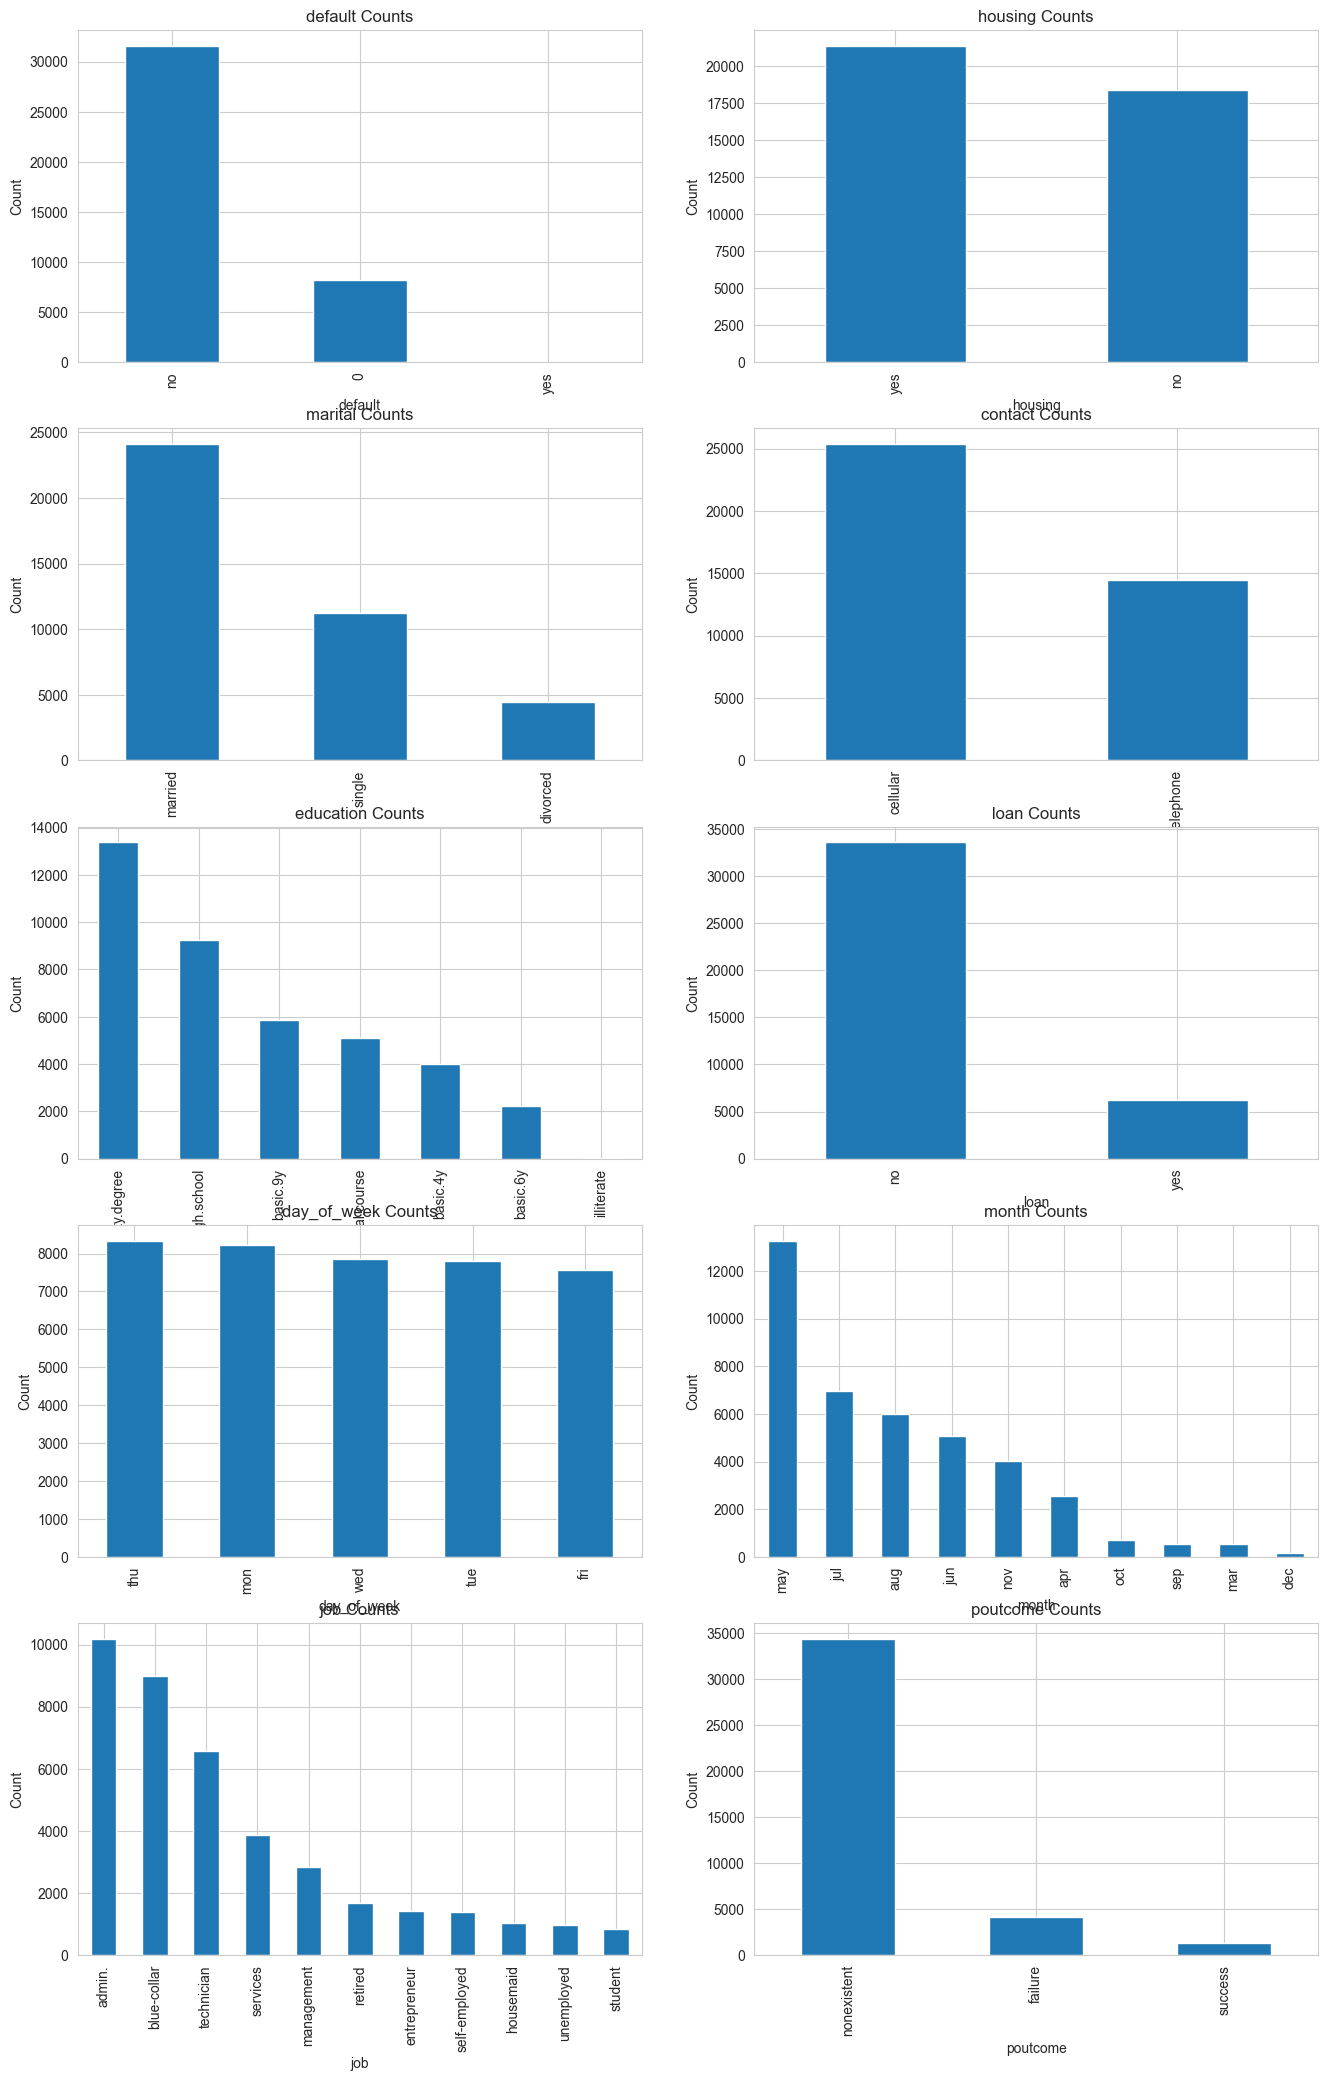

In [34]:
categ_feat_distribution()

Almost every variable is dominated by one group. The loan status shows a strong imbalance with most of the clients not having a loan. Similarly, *default* is strongly dominated with 'no' with only few 'yes' entries. *job* variable is dominated by 'admin', education by 'university.degree', *contact* by 'cellular', *marital* by 'married' and *month* by 'may'. Only values of *housing* and *day_of_week* are distributed similarly.

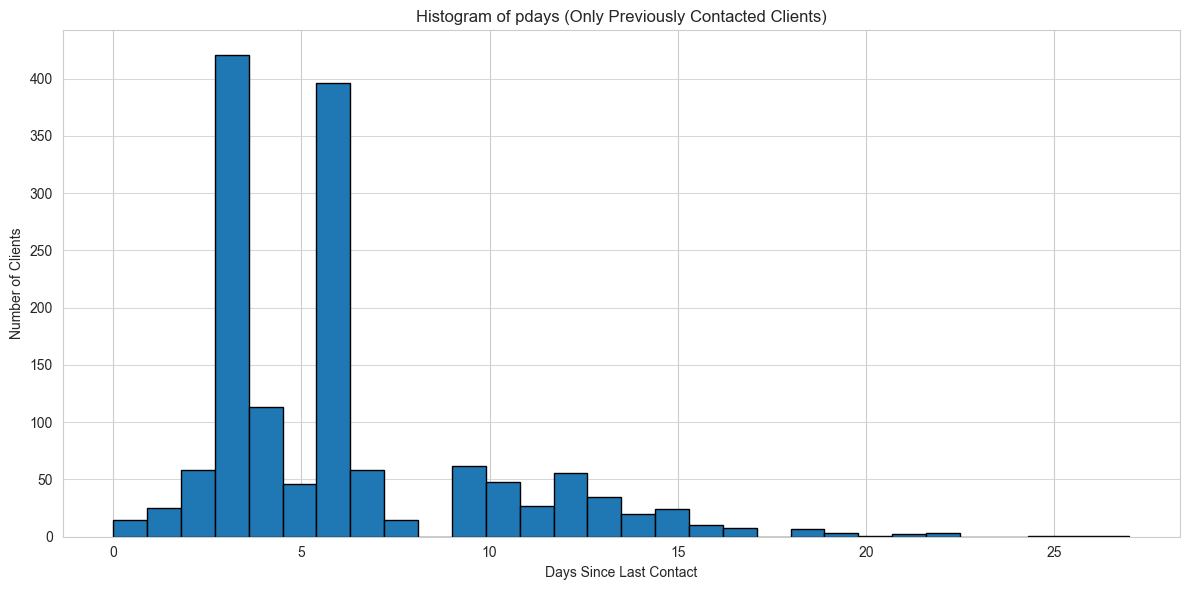

In [35]:
plt.figure(figsize=(12, 6))

# Filter out -1 (i.e., only keep rows where pdays != -1)
plt.hist(df[df['pdays'] != -1]['pdays'], bins=30, edgecolor='black')

plt.title('Histogram of pdays (Only Previously Contacted Clients)')
plt.xlabel('Days Since Last Contact')
plt.ylabel('Number of Clients')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

We omitted '-1' values for the analysis purposes. 
*pdays* variable is not severly skewed but has two peaks.


### 3.2 Bivariate analysis

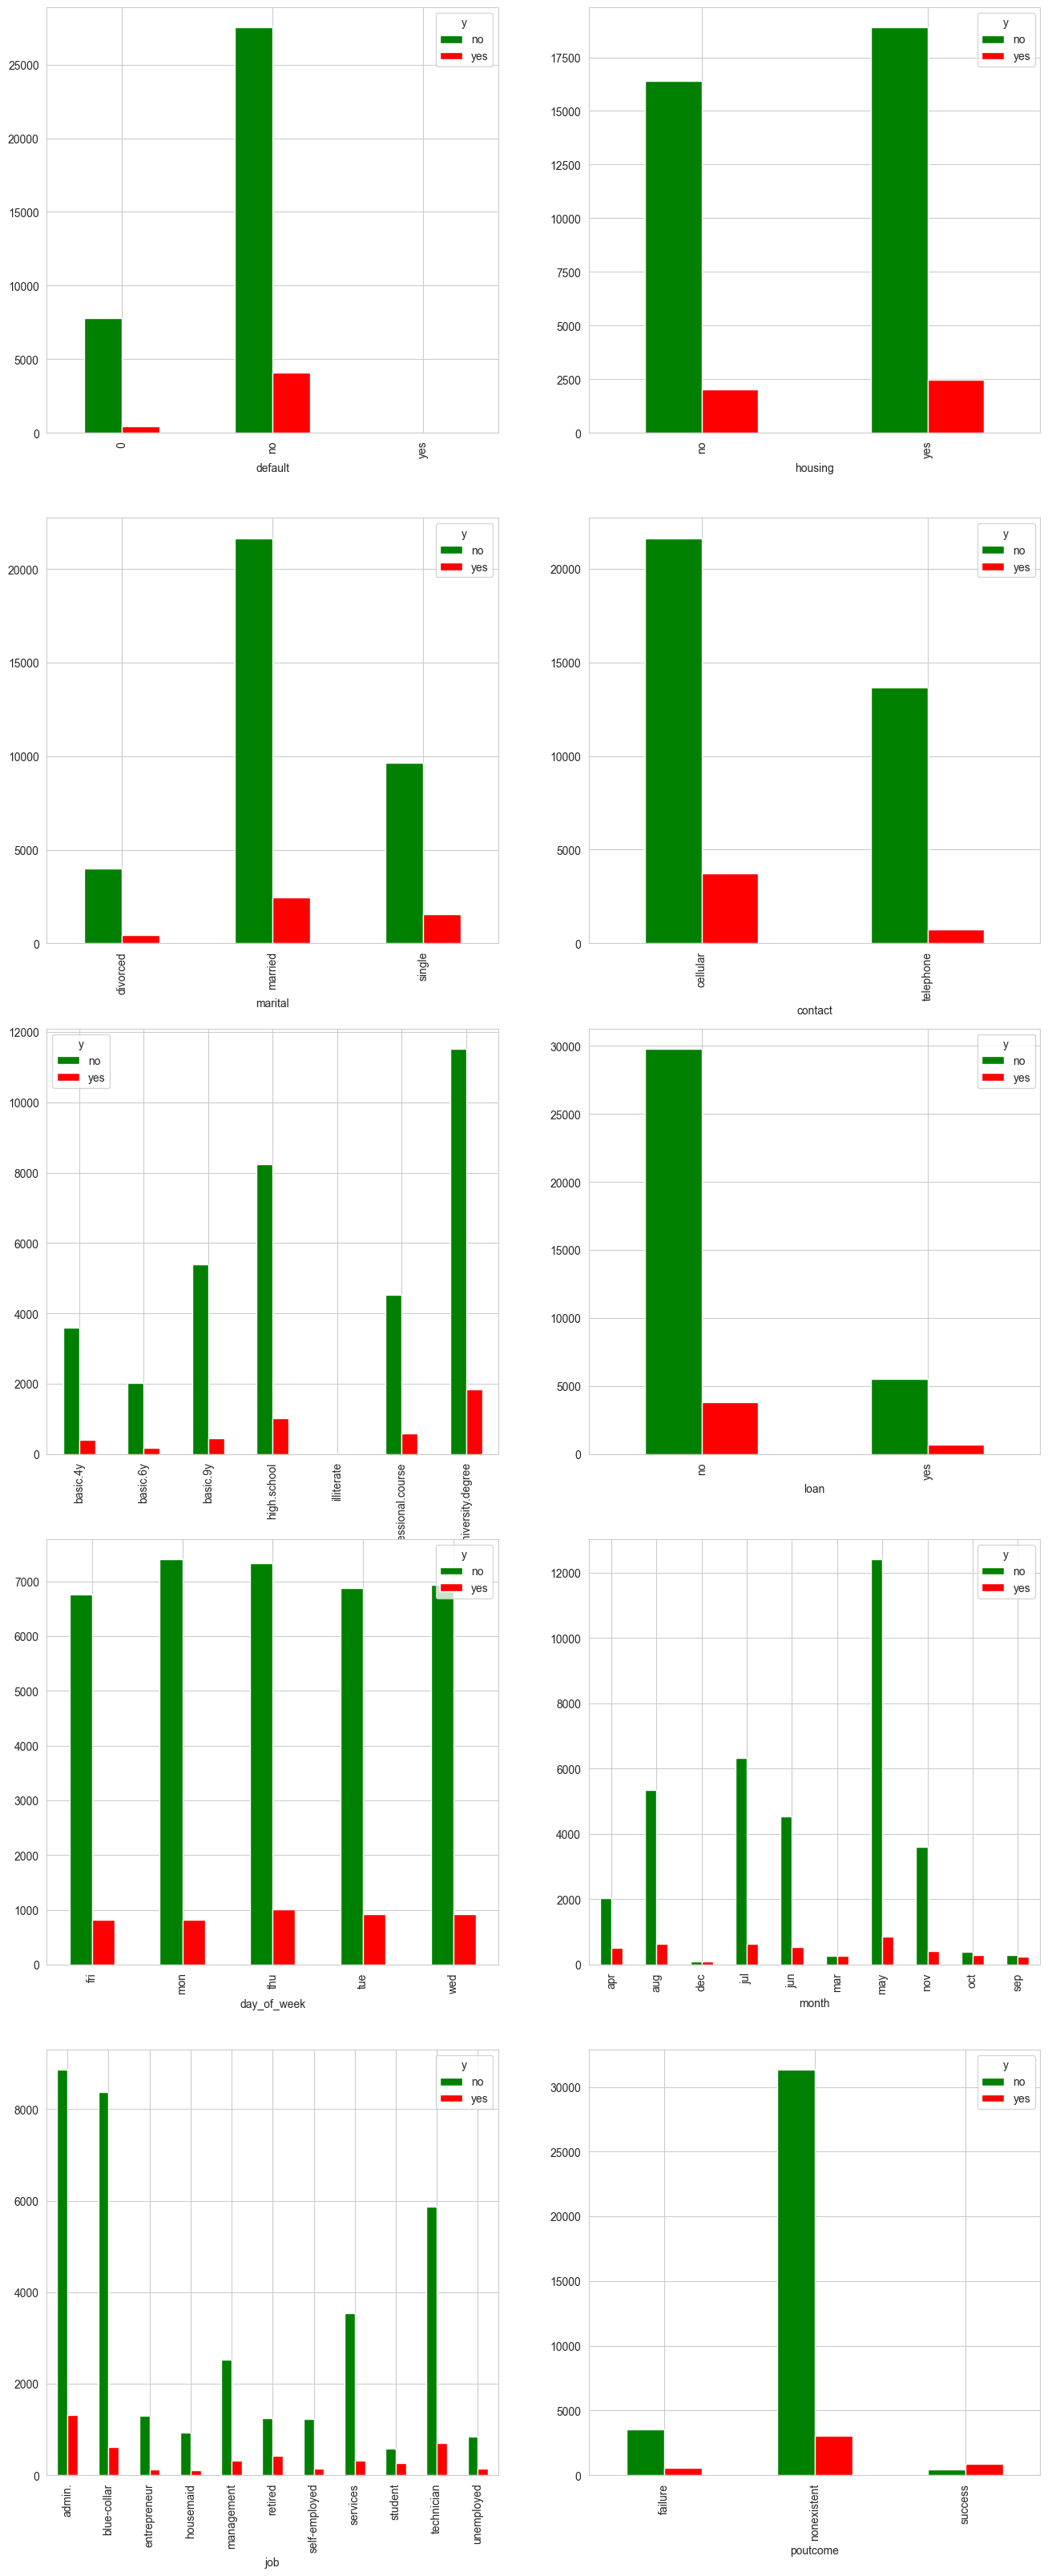

In [36]:
fig, PlotCanvas = plt.subplots(nrows=math.ceil(len(categFeatures)/2), ncols=2, figsize=(16, 40))

# Creating Grouped bar plots for each categorical predictor against the Target Variable "class"
lin = 0
for i, Categcol in enumerate(categFeatures):
    col = i%2   
    CrossTabResult=pd.crosstab(index=df[Categcol], columns=df['y'])
    CrossTabResult.plot.bar(color=['green','red'], ax=PlotCanvas[lin,col])
    if i%2 == 1:
        lin = lin+1
    

These grouped bar charts display the frequency on the Y-axis and the category values on the X-axis. If the proportions of the target variable (e.g., 'yes' vs. 'no') are similar across all categories of a feature, it suggests that there is little to no relationship between that feature and the target.

For example, if we look at a hypothetical plot like *day of week* vs. *y*, and observe that each day of a week has a similar 'yes' to 'no' ratio, it indicates that the day of week likely has no significant influence on *y*. In such cases, the feature and the target variable are likely not correlated. It can be also observed on the plot depicting *default* vs. *y*, *housing* vs. *y* and *loan* vs. *y*, which means that *default*, *housing* and *loan* are likely not correlated to *y*. 

However, there are a few variables that seems to be strongly correlated to *y*. Namely, *marital*, *poutcome*, *contact*, *job* and *education*. These variables do not maintain consistent proportions across the target classes.

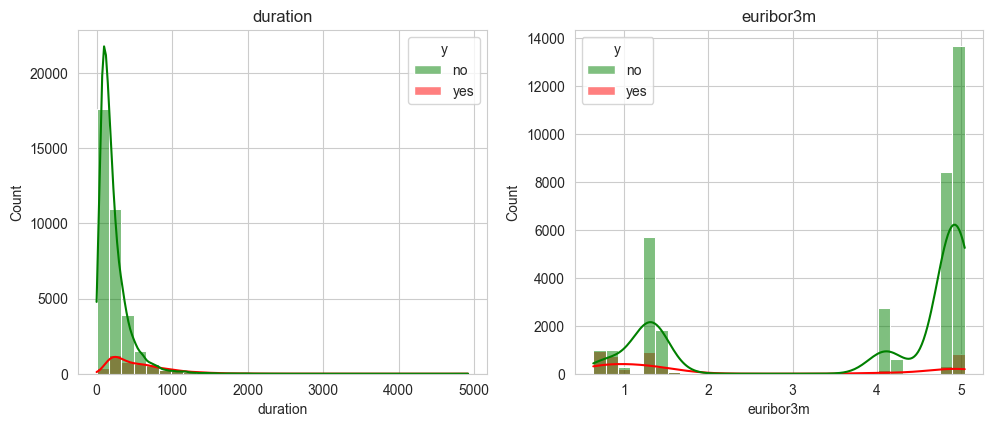

['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']


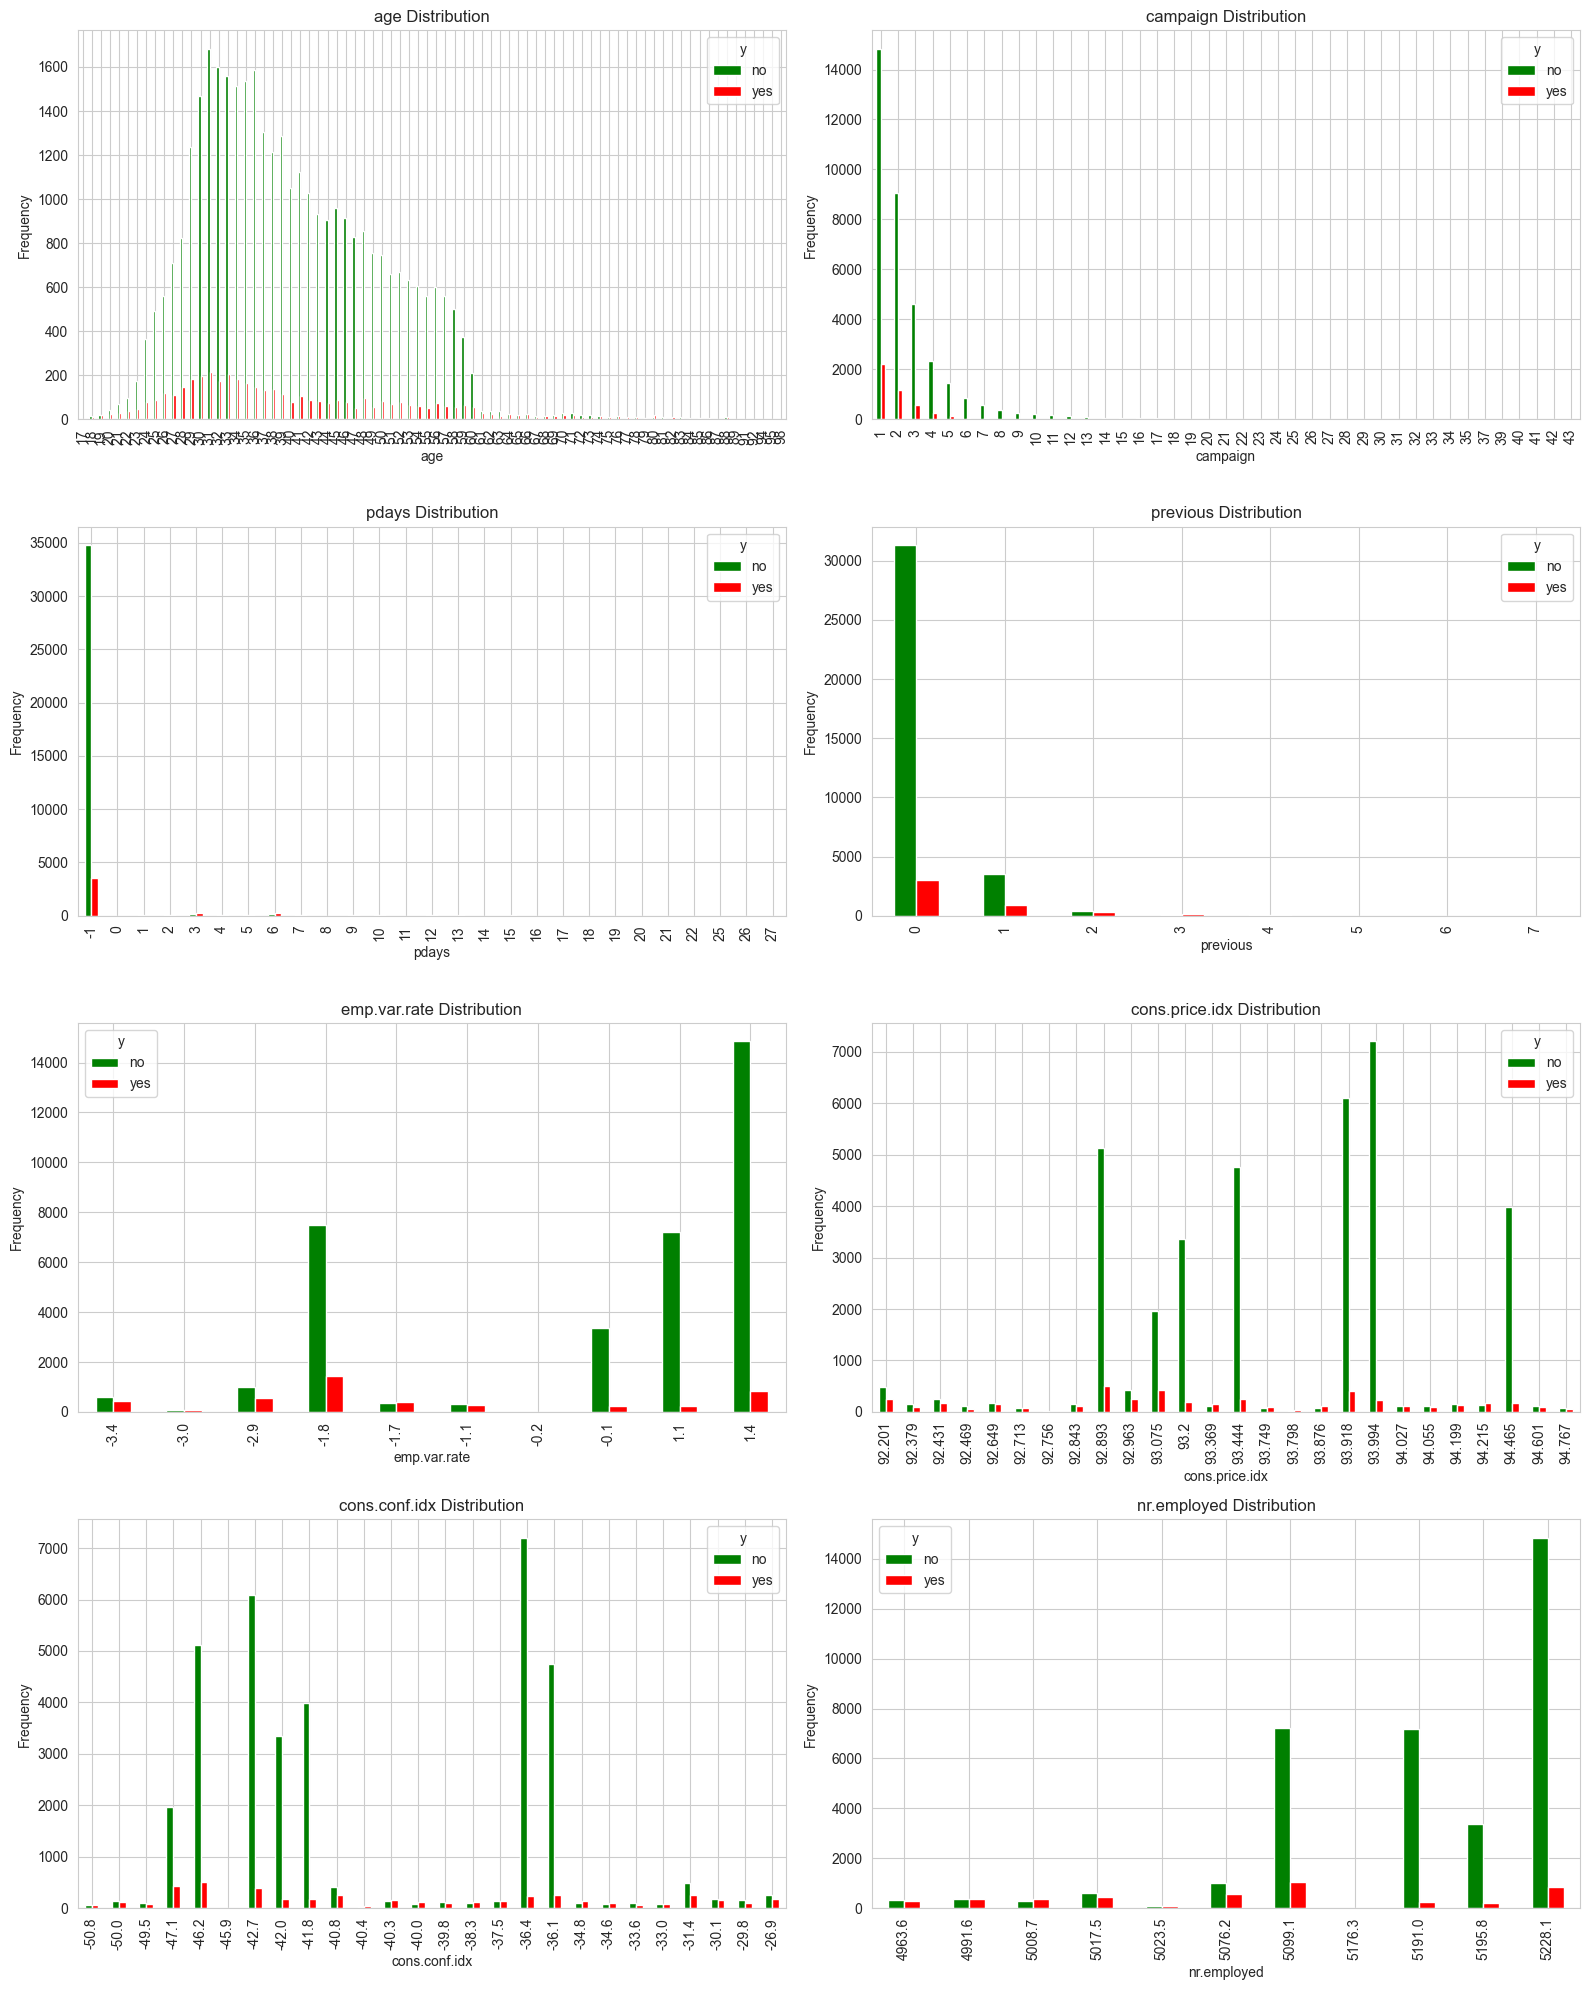

In [37]:
num_features = len(numericFeatures)
cols = 3
rows = math.ceil(num_features / cols)

# histograms for continous data
plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(nonDiscreteFeatures):
    plt.subplot(rows, cols, i + 1)
    if feature == 'pdays':
        sns.histplot(data=df[df['pdays'] != -1], x='pdays', hue='y', kde=True, bins=30, palette={"yes": "red", "no": "green"})
    else:
        sns.histplot(df, x=feature, hue='y', kde=True, bins=30, palette={"yes": "red", "no": "green"})
    plt.title(feature)

plt.tight_layout()
plt.show()

print(discreteFeatures)

# bar plot for discrete features

nrows = math.ceil(len(discreteFeatures) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))
axes = axes.flatten()  # flatten for easy linear indexing

for i, Categcol in enumerate(discreteFeatures):
    ax = axes[i]
    CrossTabResult = pd.crosstab(index=df[Categcol], columns=df['y'])
    CrossTabResult.plot.bar(color=['green', 'red'], ax=ax)
    ax.set_title(f'{Categcol} Distribution')
    ax.set_xlabel(Categcol)
    ax.set_ylabel('Frequency')

# Hide any unused axes
for j in range(len(discreteFeatures), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Every variable except for *pdays* is dominated by 'no' class and *pdays* is dominated by 'yes' class, which means all of the variables are relevant for the predictions.

### 3.4 Data Transformation

#### 3.4.1 Encoding categorical variables

To enable models to use the dataframe, data transformation, including encoding categorical variables must be conducted. Each variable with only two values ('yes' and 'no' in this dataframe) will be changed to '1' and '0'.

In [38]:
dfML = df.copy()

engineerNumericFeatures = list(dfML.select_dtypes(include='number').columns)
engineerCategFeatures = list(set(dfML.columns) - set(numericFeatures))

encode_categ_feat(dataset=dfML, cols=engineerCategFeatures)

dfML.info()

default
['no' 0 'yes']
housing
['no' 'yes']
[0 1]
marital
['married' 'single' 'divorced']
contact
['telephone' 'cellular']
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'university.degree' 'illiterate']
y
['no' 'yes']
[0 1]
loan
['no' 'yes']
[0 1]
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'entrepreneur' 'student']
poutcome
['nonexistent' 'failure' 'success']
<class 'pandas.core.frame.DataFrame'>
Index: 39791 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             39791 non-null  int64  
 1   job             39791 non-null  object 
 2   marital         39791 non-null  object 
 3   education       39791 non-null  object 
 4   default         39791 non-null  object

#### 3.4.2 Feature Engineering

We will perform feature engineering alongside data transformation, because we had to first encode the categorical values.

There are a lot of categorical variables with multiple possible values. We will use `get_dummies()` function to one-hot encode them. This allows models that require numerical input to process categorical data effectively.

In [39]:
dfML = pd.get_dummies(dfML, drop_first=True, dtype=int)

dfML.rename({'y_yes': 'y'}, axis='columns', inplace = True)

dfML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39791 entries, 0 to 41187
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            39791 non-null  int64  
 1   housing                        39791 non-null  int64  
 2   loan                           39791 non-null  int64  
 3   duration                       39791 non-null  int64  
 4   campaign                       39791 non-null  int64  
 5   pdays                          39791 non-null  int64  
 6   previous                       39791 non-null  int64  
 7   emp.var.rate                   39791 non-null  float64
 8   cons.price.idx                 39791 non-null  float64
 9   cons.conf.idx                  39791 non-null  float64
 10  euribor3m                      39791 non-null  float64
 11  nr.employed                    39791 non-null  float64
 12  y                              39791 non-null  int6

We will also create a new variable - *never_contacted* - related to the variables: *previous* and *pdays*. Value '1' will indicate that the client has never been called by another campaign.

In [40]:
dfML.insert(
    loc = dfML.columns.get_loc('pdays') + 1,  # insert after 'pdays'
    column = 'never_contacted',
    value = (dfML['pdays'] == -1).astype(int)
)

In [41]:
dfML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39791 entries, 0 to 41187
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            39791 non-null  int64  
 1   housing                        39791 non-null  int64  
 2   loan                           39791 non-null  int64  
 3   duration                       39791 non-null  int64  
 4   campaign                       39791 non-null  int64  
 5   pdays                          39791 non-null  int64  
 6   never_contacted                39791 non-null  int64  
 7   previous                       39791 non-null  int64  
 8   emp.var.rate                   39791 non-null  float64
 9   cons.price.idx                 39791 non-null  float64
 10  cons.conf.idx                  39791 non-null  float64
 11  euribor3m                      39791 non-null  float64
 12  nr.employed                    39791 non-null  floa

#### 3.4.3 Handling variables with skewed distribution

Since not all of the skewed distrubutions concern variables with positive values we will use **Yeo-Johnson** scaler.

In [42]:
# Cast to float before transformation to avoid dtype issues
cols_to_convert = skewed_cols + outliers_cols
dfML = dfML.copy()

for col in cols_to_convert:
    dfML[col] = dfML[col].astype(float)

In [43]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')

print(df[skewed_cols].dtypes)

dfML.loc[:, skewed_cols] = pt.fit_transform(dfML.loc[:, skewed_cols])

duration    int64
campaign    int64
previous    int64
dtype: object


#### 3.4.4 Handling outliers

As indicated in paragraph `3.1`, we will use **Robust Scaler** to handle outliers.

In [44]:
# Feature scaling

# Initialize the scaler
scaler = RobustScaler()

print(outliers_cols)
print(type(outliers_cols))

# Fit the scaler on the numeric features and transform
dfML.loc[:,outliers_cols] = scaler.fit_transform(dfML[outliers_cols])

['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.conf.idx']
<class 'list'>


#### 3.4.5 Dropping unnecessary variables

We will drop *duration* variable since it highly affects the otput target, yet the value is not known before the class is made.

In [45]:
dfML.drop(columns='duration', axis=1, inplace=True)

### 3.5 Data Splitting

To evaluate the models used in paragraph `4` we have to split dataset into a train and a test set. We will use an 80/20 split ratio to ensure sufficient amount of data for training while retaining enough samples for meaningful evaluation.
Additionally, stratified sampling will applied to preserve the distribution of the target variable across both subsets, preventing bias during model evaluation.

In [46]:
X = df.drop(columns=['y','duration'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Original dataframe
# Combine features and target for training set
train_df = X_train.copy()
train_df['y'] = y_train

# Combine features and target for testing set
test_df = X_test.copy()
test_df['y'] = y_test


# This second dataframe is processed

X = dfML.drop(columns=['y'])
y = dfML['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_imbalance = X_train.copy()
train_imbalance['y'] = y_train


To address class imbalance we will apply **SMOTETomek method**, a hybrid sampling technique that combines SMOTE (Synthetic Minority Over-sampling Technique) and Tomek links cleaning. This helps create a clearer separation between classes, which enables the model to learn more effectively and improve its ability to correctly identify minority class instances.

In [47]:
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

In [48]:
train_dfML = X_train_resampled.copy()
train_dfML['y'] = y_train_resampled

test_dfML = X_test.copy()
test_dfML['y'] = y_test

### 3.5 Feature Selection

By choosing only important features, model complexity is reduced and training efficiency is improved. To handle that we will use both filter and embedded methods.

#### 3.5.1 Filter Methods

**Statistical Feature Selection**

* Categorical vs Continuous---- ANOVA test
* Categorical vs Categorical--- Chi-Square test

**Categorical vs categorical using Chi-Square Test**

Chi-Square test is conducted to check the correlation between two categorical variables
 - Assumption(H0): The two columns are NOT related to each other
 - Result of Chi-Sq Test: The Probability of H0 being True

In [49]:
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    # Creating an empty list of final selected predictors
    FiltPredictors=[]

    for predictor in CategoricalVariablesList:
        CrossTabResult=pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        
        # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1]) 
            FiltPredictors.append(predictor)
            
    return(FiltPredictors)

In [50]:
newCategFeatures = []
for categCol in categFeatures:
    newCategFeatures.extend([col for col in dfML.columns if col.startswith(categCol)])

print(numericFeatures)
newNumericFeatures = numericFeatures
newNumericFeatures.remove('duration')

print('Categorical Features:', newCategFeatures)
print('Numerical Features:', newNumericFeatures)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical Features: ['default_no', 'default_yes', 'housing', 'marital_married', 'marital_single', 'contact_telephone', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'loan', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'poutcome_nonexistent', 'poutcome_success']
Numerical Features: ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [51]:
filterCateg = FunctionChisq(inpData=train_dfML, TargetVariable='y', CategoricalVariablesList=newCategFeatures)

default_no is correlated with y | P-Value: 8.299849852268718e-223
default_yes is NOT correlated with y | P-Value: 0.24820044146916553
housing is correlated with y | P-Value: 1.9769007864972776e-100
marital_married is correlated with y | P-Value: 7.151874793511775e-186
marital_single is correlated with y | P-Value: 7.088674197417727e-16
contact_telephone is correlated with y | P-Value: 0.0
education_basic.6y is correlated with y | P-Value: 5.6558064831593186e-96
education_basic.9y is correlated with y | P-Value: 4.436562837207894e-255
education_high.school is correlated with y | P-Value: 6.68405615830708e-77
education_illiterate is NOT correlated with y | P-Value: 0.3864254738925721
education_professional.course is correlated with y | P-Value: 1.7055704338757384e-85
education_university.degree is correlated with y | P-Value: 9.296086723330068e-26
loan is correlated with y | P-Value: 7.790667563666013e-290
day_of_week_mon is correlated with y | P-Value: 9.539489366830795e-228
day_of_week

The Chi-square test proves that *default_yes* is not correlated with y, which was shown on the plots (3.2). *education_illiterate* is also not correlated.

**Continuous vs categorical using ANOVA test**
 
   - Assumption(H0): There is NO relation between the given variables (i.e. the average(mean) values of the numeric    predictor variable is same for all the groups in the categorical Target variable)

ANOVA Test result: Probability of H0 being true

In [52]:
def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    # Creating an empty list of final selected predictors
    FiltPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        # Handle special cases for predictors (e.g., exclude -1 for pdays)
        if predictor == 'pdays':
            data = inpData[inpData[predictor] != -1]
        else:
            data = inpData
        
        # Group the data by the target variable and get lists of values per group
        CategoryGroupLists = data.groupby(TargetVariable)[predictor].apply(list)
        
        # If any group is constant (only one unique value), f_oneway will raise warning or error
        # So check for constant groups and skip ANOVA if found
        if any([len(set(group)) <= 1 for group in CategoryGroupLists]):
            print(f"Skipping ANOVA for '{predictor}' because one or more groups have constant values.")
            FiltPredictors.append(predictor)  # Consider skipping or adding to filtered
            continue
        
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0 (significant)
        if AnovaResults[1] < 0.05:
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            FiltPredictors.append(predictor)
            
    return FiltPredictors


In [53]:
# Calling the function to check which numeric variables are correlated with target
# df_anova = train_dfML[train_dfML['pdays'] != -1] # remove -1s


for col in newNumericFeatures:
    grouped = dfML.groupby('y')[col]
    for name, group in grouped:
        if group.nunique() <= 1:
            print(f"Feature '{col}' is constant for target group '{name}'")

filterNumeric = FunctionAnova(inpData=train_dfML, TargetVariable='y', ContinuousPredictorList = newNumericFeatures)

##### ANOVA Results ##### 

age is correlated with y | P-Value: 1.3824278809065961e-18
campaign is correlated with y | P-Value: 1.3163910657106428e-186
pdays is correlated with y | P-Value: 0.0
previous is correlated with y | P-Value: 0.0
emp.var.rate is correlated with y | P-Value: 0.0
cons.price.idx is correlated with y | P-Value: 0.0
cons.conf.idx is correlated with y | P-Value: 7.044021429311534e-78
euribor3m is correlated with y | P-Value: 0.0
nr.employed is correlated with y | P-Value: 0.0


In [54]:
FilterColumns = filterCateg + filterNumeric

print(f"Removed features by Filter methods: {FilterColumns}")

df1 = train_dfML.copy()
df1_imbalance = train_imbalance.copy()

print(df1.columns.tolist())

df1.drop(columns=FilterColumns, axis=1, inplace=True)
df1_imbalance.drop(columns=FilterColumns, axis=1, inplace=True)

df1_test = test_dfML.copy()
df1_test.drop(columns=FilterColumns, axis=1, inplace=True)

df1.info()

Removed features by Filter methods: ['default_yes', 'education_illiterate']
['age', 'housing', 'loan', 'campaign', 'pdays', 'never_contacted', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'default_no', 'default_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success', 'y']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56146 entries, 0 to 56145
Data columns (total 47 colu

Filter methods removed two variables: *default_yes* and *education_illiterate*.

#### 3.5.2 Embedded method - Lasso regularization

In [55]:
def lasso_regularization(df):

    X = df.iloc[:,:-1].copy()          
    y = df.iloc[:,-1].copy() 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    scaler.fit(X_train)

    # fit a Logistic Regression model and feature selection altogether 
    # select the Lasso (l1) penalty.
    # The selectFromModel class from sklearn, selects the features which coefficients are non-zero

    sel_ = SelectFromModel(LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

    sel_.fit(scaler.transform(X_train), y_train)

    # make a list with the selected features
    selected_feat = X_train.columns[(sel_.get_support())]
    
    print("Number of features which coefficient was shrank to zero: ", np.sum(sel_.estimator_.coef_ == 0))
    # identify the removed features like this:
    removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    print('Removed features by Lasso: ',removed_feats) 

    return X_train.columns[(sel_.estimator_.coef_ != 0).ravel().tolist()]

In [56]:
Lasso_SelectedColumns = lasso_regularization(train_dfML)

Lasso_SelectedColumns

Number of features which coefficient was shrank to zero:  1
Removed features by Lasso:  Index(['nr.employed'], dtype='object')


Index(['age', 'housing', 'loan', 'campaign', 'pdays', 'never_contacted',
       'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'default_no', 'default_yes', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

Embedded method removed no variables, therefore we will not create a separate dataset.

With these methods, we prepared a dataframes for future testing and tuning to compare different models and select the one with the best performance.

---
## 4. Modeling

### 4.1 Evaluation metric selection

To properly evaluate models and select the best one, it's necessary to choose the right metric. Because the problem of predicting bank deposit subscriptions is imbalanced (our dataset contains significantly more examples of the negative ("no") class than the positive ("yes") class) we decided to choose the AUC-PR (Area Under the Precision–Recall Curve) metric.This metric is more sensitive to the correct classification of the rare class (i.e., y = 'yes') as it reflects how well the model identifies true positive cases while avoiding false positives. It combines two key measures:
- **Recall** - determines how many of the actual positives were correctly detected by the model.

    𝑟𝑒𝑐𝑎𝑙𝑙 = 𝑇𝑃 / (𝑇𝑃 + 𝐹𝑁)
- **Precision** - determines how many of the detected cases are actually positive

    𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 = 𝑇𝑃 / (𝑇𝑃 + 𝐹𝑃)

The Precision–Recall (PR) curve shows how the model balances these two aspects, and AUC-PR reduces it to a single metric. This allows for a more objective assessment of model performance than metrics like Accuracy or AUC-ROC, which can make the results much higher by omitting the problem of the minority of the positive class. In our case, we want to minimize the number of false negatives (FN) – that is, avoid a situation in which we don't call a customer who is actually interested in purchasing the product. Therefore, AUC-PR provides a more practical and realistic measure of model performance in this task, as it directly reflects the model’s ability to correctly identify rare positive cases without being biased by the large number of negatives.

In the case of the AUC-PR metric, the baseline value corresponds to the proportion of positive classes in the test set, rather than 0.5 as in the AUC-ROC. This means that a random model would achieve a score equal to this value.

In [57]:
baseline = df1_test['y'].mean()
print(baseline)

0.1127026008292499



For our dataset, the baseline AUC-PR is around 0.11. This means that a random model would achieve this result, and any result above this value indicates better performance in identifying rare positive cases.

Despite the selection of the primary metric, our analysis also examined other metrics useful in classification problems. This will allow us to more comprehensively assess model quality, as each metric highlights a different aspect of the classifier's performance. These metrics include:
- Accuracy
- Recall
- Precision
- F1 score
- AUC-ROC

In addtion to that, to evaluate the model performance, training and prediction times will be checked.

### 4.2 Baseline models

The analysis of model training, evaluation, and comparison begins with testing several baseline algorithms such as KNN, Decision Tree, SVM, Naive Bayes, and Logistic Regression. This step provides a foundation and reference point for further experiments involving hyperparameter tuning and the development of ensemble learning models and a neural network.

The dataset is split into features (X) and target (y) for both the training and test sets. In addition to that we also include a train sets with imbalance data (without SMOTETomek method) in order to use it in hyperparameter tuning and a scaled version of train and test sets. Scaling is especially important for algorithms sensitive to feature magnitude, such as K-Nearest Neighbors (KNN), Support Vector Machine (SVM), and Logistic Regression.

In [58]:
X_train_model = df1.drop(columns=['y'])
y_train_model = df1['y']
X_train_imb = df1_imbalance.drop(columns=['y'])
y_train_imb = df1_imbalance['y']

X_test_model = df1_test.drop(columns=['y'])
y_test_model = df1_test['y']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_test_scaled = scaler.transform(X_test_model)
results = []

In [59]:
def add_or_replace_result(model_name, new_result):
    for i, r in enumerate(results):
        if r['Model'] == model_name:
            results[i] = new_result
            return
    results.append(new_result)

In [60]:
def evaluation(model_name, y_pred, y_proba, train_time, pred_time):
    # Evaluation (accuracy, recall, precision, AUC-PR, AUC-ROC, f1 score, confusion matrix)
    accuracy = accuracy_score(y_test_model, y_pred)
    recall = recall_score(y_test_model, y_pred)
    precision = precision_score(y_test_model, y_pred)
    f1 = f1_score(y_test_model, y_pred)
    cm= confusion_matrix(y_test_model, y_pred)
    prec, rec, threshold = precision_recall_curve(y_test_model, y_proba)
    auc_pr = average_precision_score(y_test_model, y_proba)

    fpr, tpr, _ = roc_curve(y_test_model, y_proba)
    auc_roc = roc_auc_score(y_test_model, y_proba)

    print("Accuracy: ", accuracy)
    print("Recall: ", recall)
    print("Precision: ", precision)
    print("F1 score: ", f1)
    print("Confusion matrix:\n")
    plt.figure(figsize=(5,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(f"Area Under the Receiver Operating Characteristic Curve (AUC-ROC): {auc_roc:.3f}")
    print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.3f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_roc:.3f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model_name}")
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(rec, prec, label=f"AUC-PR = {auc_pr:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    new_record = {
        'Model': model_name,
        'Training time' : train_time,
        'Prediction time' : pred_time,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc,
        'AUC-PR': auc_pr
    }

    add_or_replace_result(model_name, new_record)

For the baseline models, we decided not to use cross-validation and instead evaluate performance on the test dataset. This decision was made to reduce computational time and establish an initial reference point for model performance before applying more advanced methods such as hyperparameter tuning or ensemble learning.
At this stage, the goal was not to achieve the highest possible metrics, but rather to gain a general understanding of which types of models perform better or worse on our specific classification problem.

#### K-Nearest Neighbors

The first model we will use is K-Nearest Neighbors (KNN). It is a simple machine learning algorithm that classifies data points based on the majority class among their k nearest neighbors in the feature space. It is easy to implement and interpret, making it a good starting point for comparison. Similar to the other baseline models, we will use the default parameters provided by the Scikit-learn library.

In [61]:
# Default values: n_neighbors=5, metric='minkowski', p=2
knn_basic = KNeighborsClassifier()

start_train_knn = time.time()
knn_basic.fit(X_train_scaled, y_train_model)
train_time_knn= time.time() - start_train_knn

start_pred_knn = time.time()
pred_knn = knn_basic.predict(X_test_scaled)
y_proba_knn = knn_basic.predict_proba(X_test_scaled)[:, 1]
pred_time_knn = time.time() - start_pred_knn

Accuracy:  0.7700716170373162
Recall:  0.5707915273132664
Precision:  0.2616249361267246
F1 score:  0.3587946741415557
Confusion matrix:



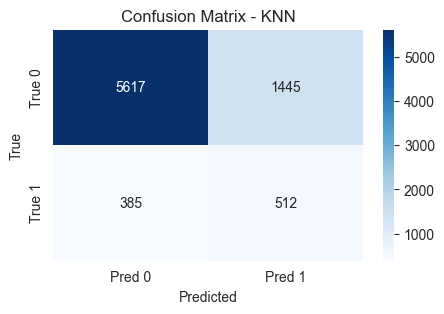

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.730
Area Under Precision-Recall Curve (AUC-PR): 0.258


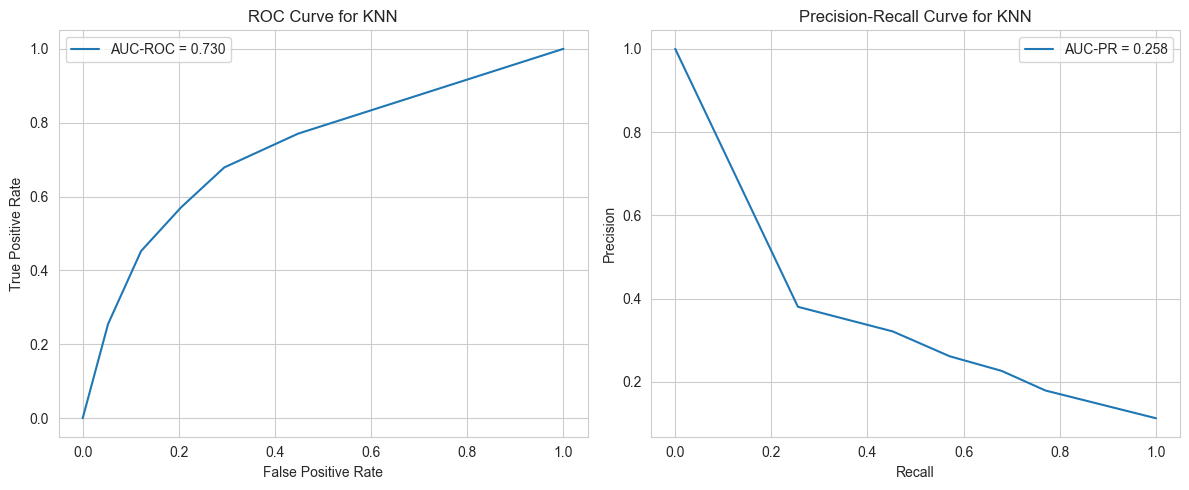

In [62]:
# Evaluation (accuracy, recall, precision, AUC-PR, f1 score, confusion matrix)
evaluation('KNN', pred_knn, y_proba_knn, train_time_knn, pred_time_knn)

The model achieves a quite high accuracy of 0.77, but in this context it is due to the dominance of the negative class and does not reflect well the quality of the model. In terms of recall, the model detects more than half of all actual positive cases. This is a fairly good result considering the model's simplicity and lack of tuning, but it still misses almost half of the customers who would actually accept the offer. The next metric, precision, achieved a relatively low value of 0.26, which indicates a high number of false positives. The low F1 score (0.36) further shows that the balance between recall and precision is weak, meaning the model struggles to correctly identify positive cases without generating many false alarms.

The main metric AUC-PR is equal to 0.258, only slightly above baseline (~0.11), which means that the model detects the positive class better than randomly, but with a large margin of error. The relatively high AUC-ROC (0.73) and the shape of the ROC curve indicate that the model has some ability to distinguish between classes. However, this metric can be misleading in the case of imbalanced data, as it may overestimate performance by focusing more on the majority class. Analysis of the confusion matrix shows that the KNN model produces a high number of false positives (FP) compared to true positives (TP). This means that the model often predicts that a client will subscribe when in reality they will not, which reduces precision and may lead to unnecessary marketing efforts.

Overall, KNN provides a good starting point and serves as a baseline for more advanced models. Its main limitations include sensitivity to feature scaling, computational inefficiency on large datasets, and reduced performance on imbalanced data.

#### Logistic Regression

Logistic Regression is a method used for predicting the probability of a binary outcome based on one or more predictor variables. It fits an S-shaped logistic function to the data to ensure the predicted output is a probability between 0 and 1. This model is simple, effective and easy to interpret – it allows to assess the impact of individual variables on the outcome and provides useful decision probabilities.

In [63]:
# Default values: penalty='l2', max_iter=100
lr_basic = LogisticRegression(random_state=42)

start_train_lr = time.time()
lr_basic.fit(X_train_scaled, y_train_model)
train_time_lr= time.time() - start_train_lr

start_pred_lr = time.time()
pred_lr = lr_basic.predict(X_test_scaled)
y_proba_lr = lr_basic.predict_proba(X_test_scaled)[:, 1]
pred_time_lr = time.time() - start_pred_lr

Accuracy:  0.7993466515893957
Recall:  0.5451505016722408
Precision:  0.29141835518474374
F1 score:  0.37980582524271844
Confusion matrix:



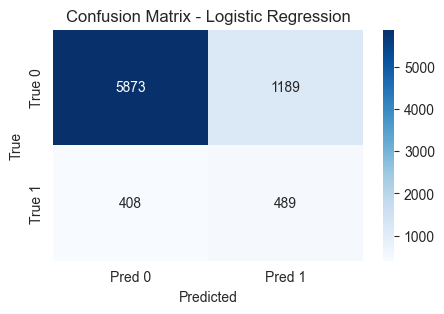

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.745
Area Under Precision-Recall Curve (AUC-PR): 0.335


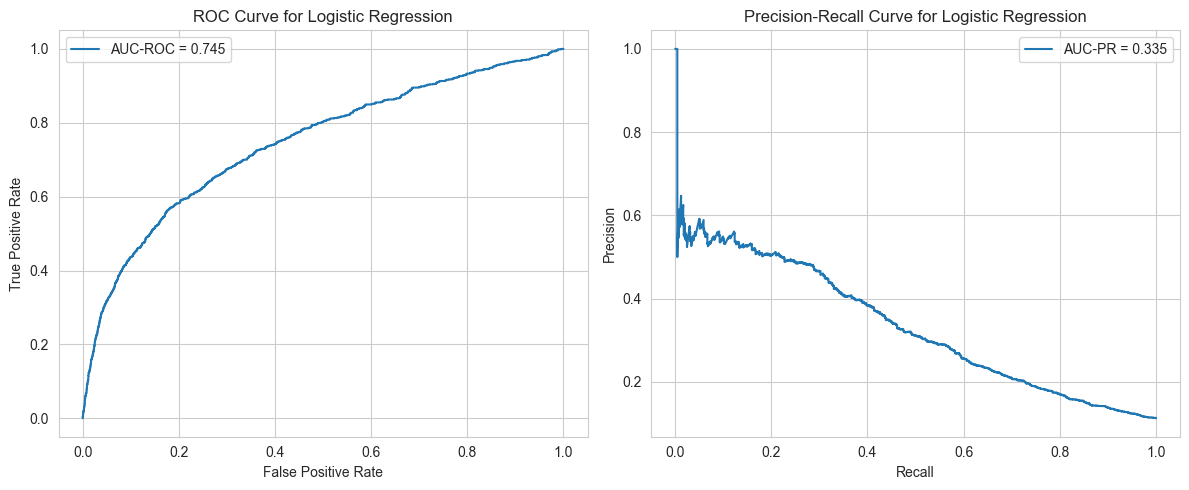

                          Feature  Importance  Coefficient
7                    emp.var.rate    2.456315    -2.456315
10                      euribor3m    1.504251     1.504251
8                  cons.price.idx    0.950230     0.950230
28    education_university.degree    0.840472    -0.840472
26          education_high.school    0.745287    -0.745287
30              contact_telephone    0.688783    -0.688783
12                job_blue-collar    0.627968    -0.627968
40                day_of_week_mon    0.592082    -0.592082
5                 never_contacted    0.558474    -0.558474
42                day_of_week_tue    0.513690    -0.513690
41                day_of_week_thu    0.511426    -0.511426
27  education_professional.course    0.491224    -0.491224
37                      month_nov    0.467160    -0.467160
25             education_basic.9y    0.459441    -0.459441
36                      month_may    0.457113    -0.457113
43                day_of_week_wed    0.441353    -0.4413

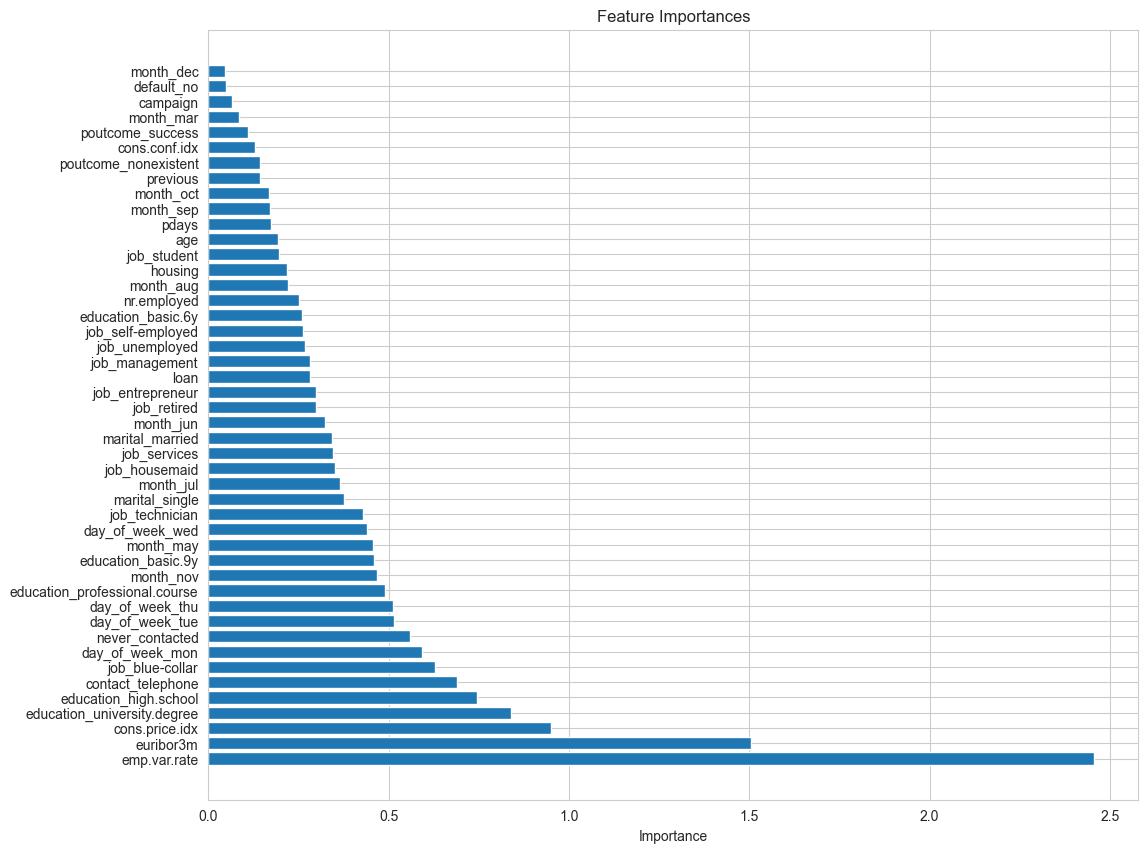

In [64]:
evaluation('Logistic Regression', pred_lr, y_proba_lr, train_time_lr, pred_time_lr)
coefficients = lr_basic.coef_[0]
importance_df = pd.DataFrame({
    'Feature': X_train_model.columns,
    'Importance': np.abs(coefficients),
    'Coefficient': coefficients
}).sort_values(by='Importance', ascending=False)
print(importance_df)

plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

Based on the accuracy metric, we can see that the model correctly classified around 80% of the data. However, is not the most reliable measure for an imbalanced dataset.
The model achieved a recall of 0.55, which is a relatively good result, indicating that it correctly identified over half of the customers who subscribed.
However, the precision of 0.29 shows that a large proportion of predicted positives were actually false alarms (FP = 1189), as seen in the confusion matrix.
The F1 score (0.38) further confirms that the model struggles to balance precision and recall.

The AUC-ROC(0.745) indicates a decent ability to distinguish between classes, but the AUC-PR = 0.335 provides a more meaningful insight for this imbalanced problem.
Since the baseline AUC-PR is 0.11, the model performs significantly better than random guessing, but still has room for improvement.

All of this means the model can accurately identify customers who are likely to open a deposit, but as we reach more potential subscribers, it also incorrectly identifies many customers who are not interested. This can result in unnecessary marketing efforts (false positives).

The Logistic Regression model assigns the highest importance to the variables related to the economic context:
- emp.var.rate - employment variation rate (quarterly indicator)
- euribor3m - euribor 3 month rate (daily indicator)
- cons.price.idx - consumer price index (monthly indicator)

It means that lower employment variation rate and lower euribor3m are associated with a higher likelihood of subscription. In other words, customers are more willing to invest during stable or low-rate economic periods. We can also see that education-related variables have negative coefficients, suggesting that individuals with higher education levels are less likely to subscribe to a term deposit.
In general, the logistic regression coefficients are consistent with the economic situation - macroeconomic variables and education level are the main predictors of term deposit subscriptions.

#### Decision Tree

Decision Tree is a non-parametric supervised learning algorithm used for classification and regression tasks. It works by recursively splitting the data into subsets based on feature values, creating a tree-like structure of decisions. Each internal node represents a decision rule on a feature, and each leaf node corresponds to a final prediction.

In [65]:
# Default values: criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1
tree_basic = DecisionTreeClassifier(random_state=42)

start_train_tree = time.time()
tree_basic = tree_basic.fit(X_train_model, y_train_model)
train_time_tree= time.time() - start_train_tree

start_pred_tree = time.time()
pred_tree = tree_basic.predict(X_test_model)
y_proba_tree  = tree_basic.predict_proba(X_test_model)[:, 1]
pred_time_tree = time.time() - start_pred_tree

Accuracy:  0.8399296394019349
Recall:  0.38461538461538464
Precision:  0.3233364573570759
F1 score:  0.3513238289205703
Confusion matrix:



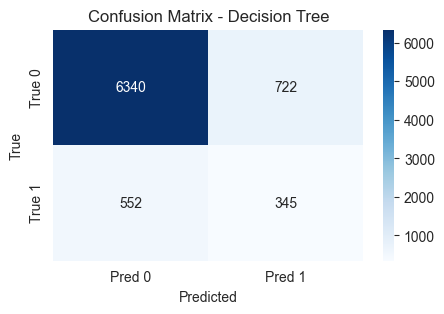

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.644
Area Under Precision-Recall Curve (AUC-PR): 0.196


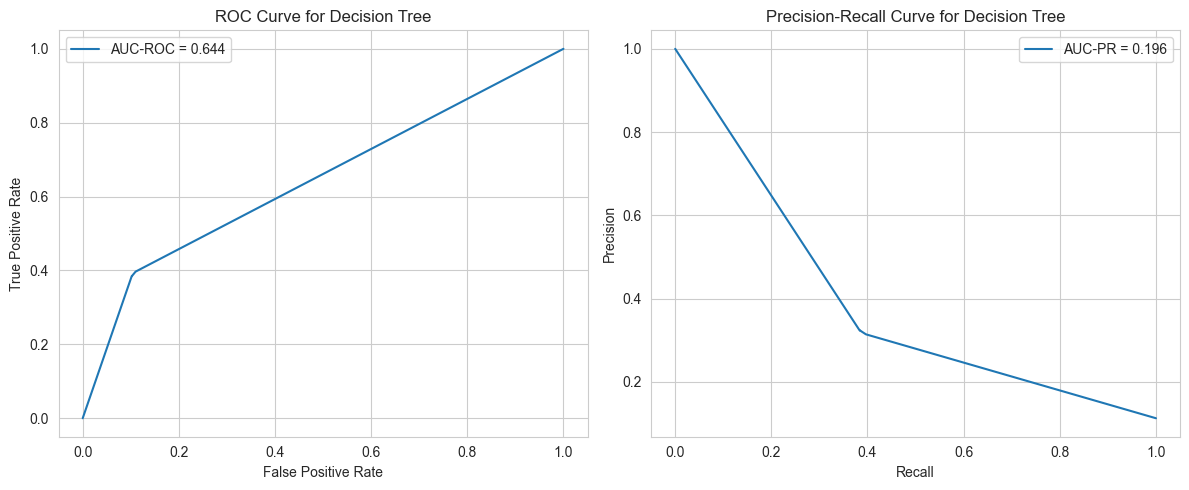

                          Feature  Importance
11                    nr.employed    0.202244
3                        campaign    0.193253
10                      euribor3m    0.190294
0                             age    0.100531
9                   cons.conf.idx    0.055582
30              contact_telephone    0.020728
1                         housing    0.016061
8                  cons.price.idx    0.012667
22                marital_married    0.012627
28    education_university.degree    0.012067
6                        previous    0.011450
2                            loan    0.011125
38                      month_oct    0.011085
26          education_high.school    0.010688
23                 marital_single    0.010118
12                job_blue-collar    0.009774
40                day_of_week_mon    0.009774
20                 job_technician    0.009191
29                     default_no    0.008596
43                day_of_week_wed    0.008541
42                day_of_week_tue 

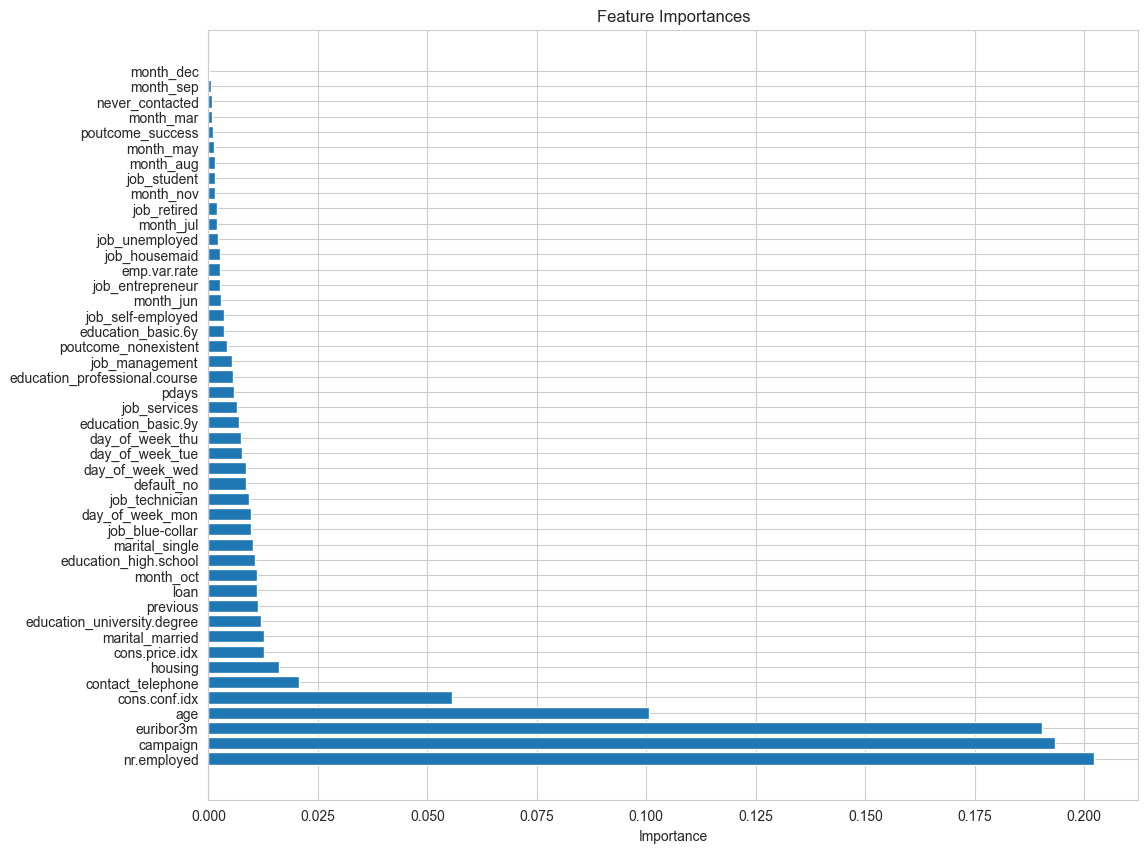

In [66]:
# Evaluation (accuracy, recall, precision, AUC-PR, f1 score, confusion matrix)
evaluation('Decision Tree', pred_tree, y_proba_tree, train_time_tree, pred_time_tree)
feature_names = X_train_model.columns
importances = tree_basic.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In the case of the Decision Tree, the situation is similar to the previous models - although the accuracy is relatively high (around 84%), it is misleading due to the class imbalance. The recall, precision, and F1-score remain at a similar level (around 0.35), which indicates that the model does not achieve a good balance between correctly identifying positive cases and avoiding false alarms. From the confusion matrix, we can see relatively few true positives (345) and a significant number of false negatives (552), meaning the model fails to identify many customers who would actually subscribe. There is also a noticeable number of false positives (722), though smaller than in other models.

The AUC-PR value of 0.196 is only slightly above the baseline (~0.11), suggesting that the model struggles to effectively distinguish positive cases. The Precision-Recall curve confirms this - precision drops sharply as recall increases, indicating unstable performance when the model tries to capture more positives.

Overall, while the Decision Tree provides interpretable rules and performs reasonably well on the majority class, it remains too simplistic to handle the imbalance and complexity of this dataset effectively.

The most important features identified by the Decision Tree model are:
- nr.employed-  number of employees(quarterly indicator)
- campaign - number of contacts performed during this campaign and for this client
- euribor3m - euribor 3 month rate (daily indicator)

These variables are related to the economic context and customer engagement. Lower-ranked features such as education, marital status, or month of contact have smaller contributions, suggesting that in this simple model, macroeconomic and campaign-related variables dominate decision-making.




#### Naive Bayes

Naive Bayes is a statistical classification technique based on Bayes Theorem. It is one of the simplest supervised learning algorithms and is based on an assumption that all features are independent of each other. Despite this simplification, it often performs well on high-dimensional or text-based datasets due to its efficiency and robustness. The Gaussian Naive Bayes variant is specifically designed for continuous numerical features. It assumes that these features follow a normal distribution within each class.

In [67]:
nb_basic = GaussianNB()

start_train_nb = time.time()
nb_basic.fit(X_train_model, y_train_model)
train_time_nb= time.time() - start_train_nb

start_pred_nb = time.time()
pred_nb = nb_basic.predict(X_test_model)
y_proba_nb  = nb_basic.predict_proba(X_test_model)[:, 1]
pred_time_nb = time.time() - start_pred_nb

Accuracy:  0.8483477823847217
Recall:  0.5351170568561873
Precision:  0.3779527559055118
F1 score:  0.44300876788186433
Confusion matrix:



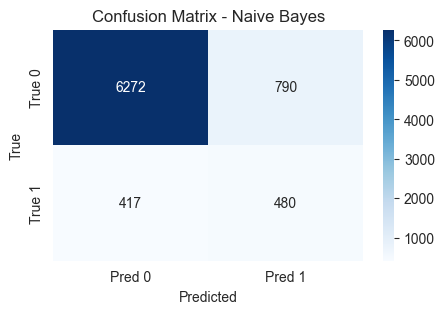

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.755
Area Under Precision-Recall Curve (AUC-PR): 0.372


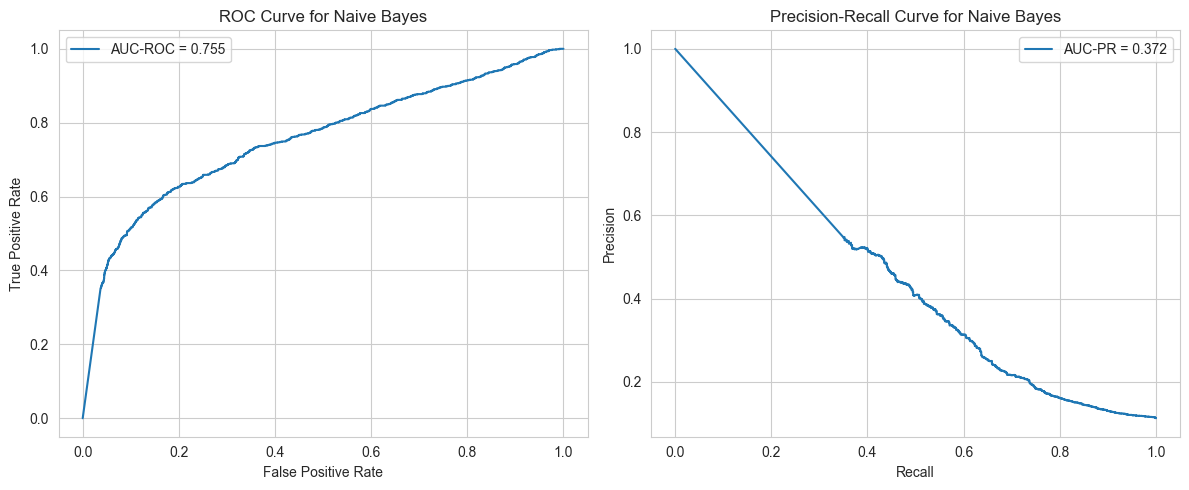

In [68]:
evaluation('Naive Bayes', pred_nb, y_proba_nb, train_time_nb, pred_time_nb)

In the case of the Naive Bayes algorithm, we can observe an accuracy of around 0.85. The precision is 0.38, the F1 score is 0.44, and the recall reaches 0.54. The relatively high recall indicates that the model correctly identified more than half of the customers who actually subscribed, which is a solid result for an imbalanced dataset. However, the lower precision value suggests that the model still produces a quite high number of false positives. It can be seen also on the confusion matrix. According to it, the model generated 790 false positives, 480 true positives, and 417 false negatives.

The AUC-PR score of 0.37 is clearly above the baseline, which means that Naive Bayes effectively distinguishes positive cases better than random guessing. The PR curve is decreasing, meaning that as the model's recall (detecting more positive results) increases, precision decreases. In other words, the model identifies more real subscribers but also generates more false positives. This trade-off is typical of probabilistic classifiers like Naive Bayes, which tend to prioritize recall over precision.

Overall, the model performs pretty well, achieving a good balance between recall and simplicity, although there is room for improvement in precision.

#### Support Vector Machines

Support Vector Machines(SVM) is a supervised machine learning algorithm used for classification and regression tasks. It tries to find the best boundary known as hyperplane that separates different classes in the data. The main goal of the algorithm is to maximize the margin between the two classes. The larger the margin the better the model performs on new and unseen data. SVM is  effective in high-dimensional spaces and can handle nonlinear relationships between features. However, it is also sensitive to feature scaling and may require careful parameter tuning.

In [69]:
# Default values: C=1.0, kernel='rbf', gamma='scale'
svm_basic = SVC(probability=True, random_state=42)

start_train_svm = time.time()
svm_basic.fit(X_train_scaled, y_train_model)
train_time_svm = time.time() - start_train_svm

start_pred_svm = time.time()
pred_svm= svm_basic.predict(X_test_scaled)
y_proba_svm = svm_basic.predict_proba(X_test_scaled)[:, 1]
pred_time_svm = time.time() - start_pred_svm

Accuracy:  0.8158060057796206
Recall:  0.48940914158305465
Precision:  0.3033863165169316
F1 score:  0.37457337883959047
Confusion matrix:



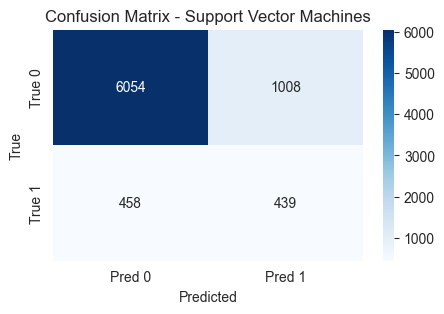

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.739
Area Under Precision-Recall Curve (AUC-PR): 0.298


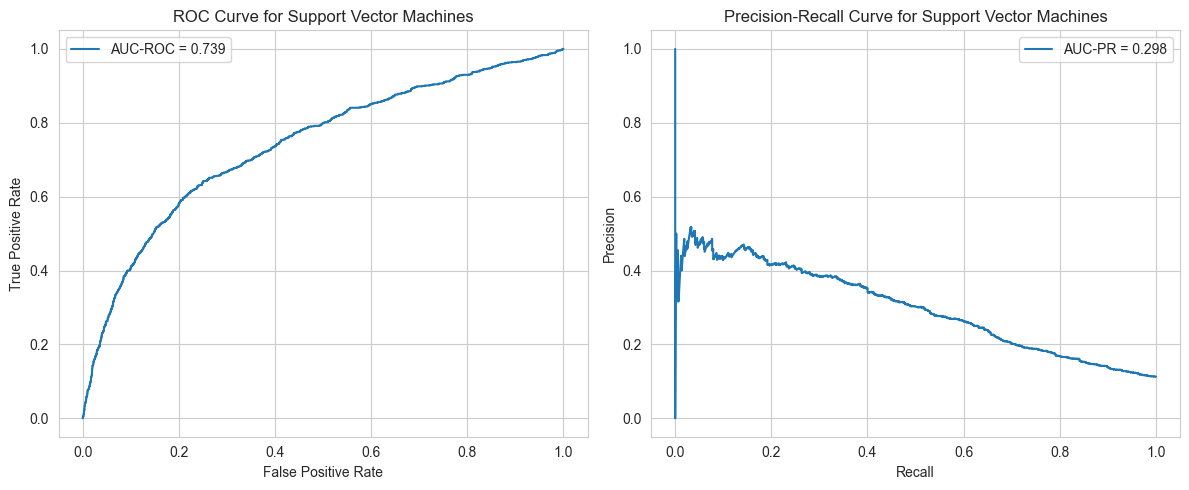

In [70]:
evaluation('Support Vector Machines', pred_svm, y_proba_svm, train_time_svm, pred_time_svm)

In the case of Support Vector Machines (SVM), the results are similar to previous models. The model achieved an accuracy of 0.82. However, metrics such as recall of 0.49 and precision of 0.3 provide a better indication of the model's quality. The F1 score, on the other hand, is 0.37. This means that the model correctly detects slightly less than half of the positive cases, but at the cost of a significant number of false positives. The confusion matrix shows 439 true positives, 458 false negatives, and 1008 false positives, confirming that the model often confuses uninterested customers with potential subscribers.

It is worth noting that AUC-PR = 0.30. This result is clearly above the baseline (0.11), suggesting that SVM identifies positive cases better than a random classifier. However, the Precision-Recall curve shows a rapid decline in precision as recall increases, meaning the model becomes less reliable as it tries to capture more positives.

SVM separates classes well in the feature space and gives a solid trade-off between recall and precision, but with strong class imbalance it would still need further optimization.


#### 4.3 Baseline models comparision

To compare the baseline models presented above, we will use a summary table and bar plots. This visual and numerical comparison will help assess the overall performance across models, highlight key differences, and identify which models are worth further tuning and analysis in the following sections of the report. Additionally, this summary provides a clear overview of how each algorithm handles the class imbalance problem, showing trade-offs between precision, recall, and overall model stability.

In [71]:
results_df = pd.DataFrame(results)
if not results_df.empty:
    results_df = results_df.sort_values(by='AUC-PR', ascending=False).reset_index(drop=True)
results_df

,Model,Training time,Prediction time,Accuracy,Precision,Recall,F1 Score,AUC-ROC,AUC-PR
0,Naive Bayes,0.033969,0.014551,0.848348,0.377953,0.535117,0.443009,0.754852,0.372059
1,Logistic Regression,0.185792,0.002972,0.799347,0.291418,0.545151,0.379806,0.745064,0.334776
2,Support Vector Machines,1128.777324,48.362856,0.815806,0.303386,0.489409,0.374573,0.739477,0.298345
3,KNN,0.010248,1.104516,0.770072,0.261625,0.570792,0.358795,0.729588,0.258171
4,Decision Tree,0.405301,0.016525,0.839930,0.323336,0.384615,0.351324,0.644349,0.196419


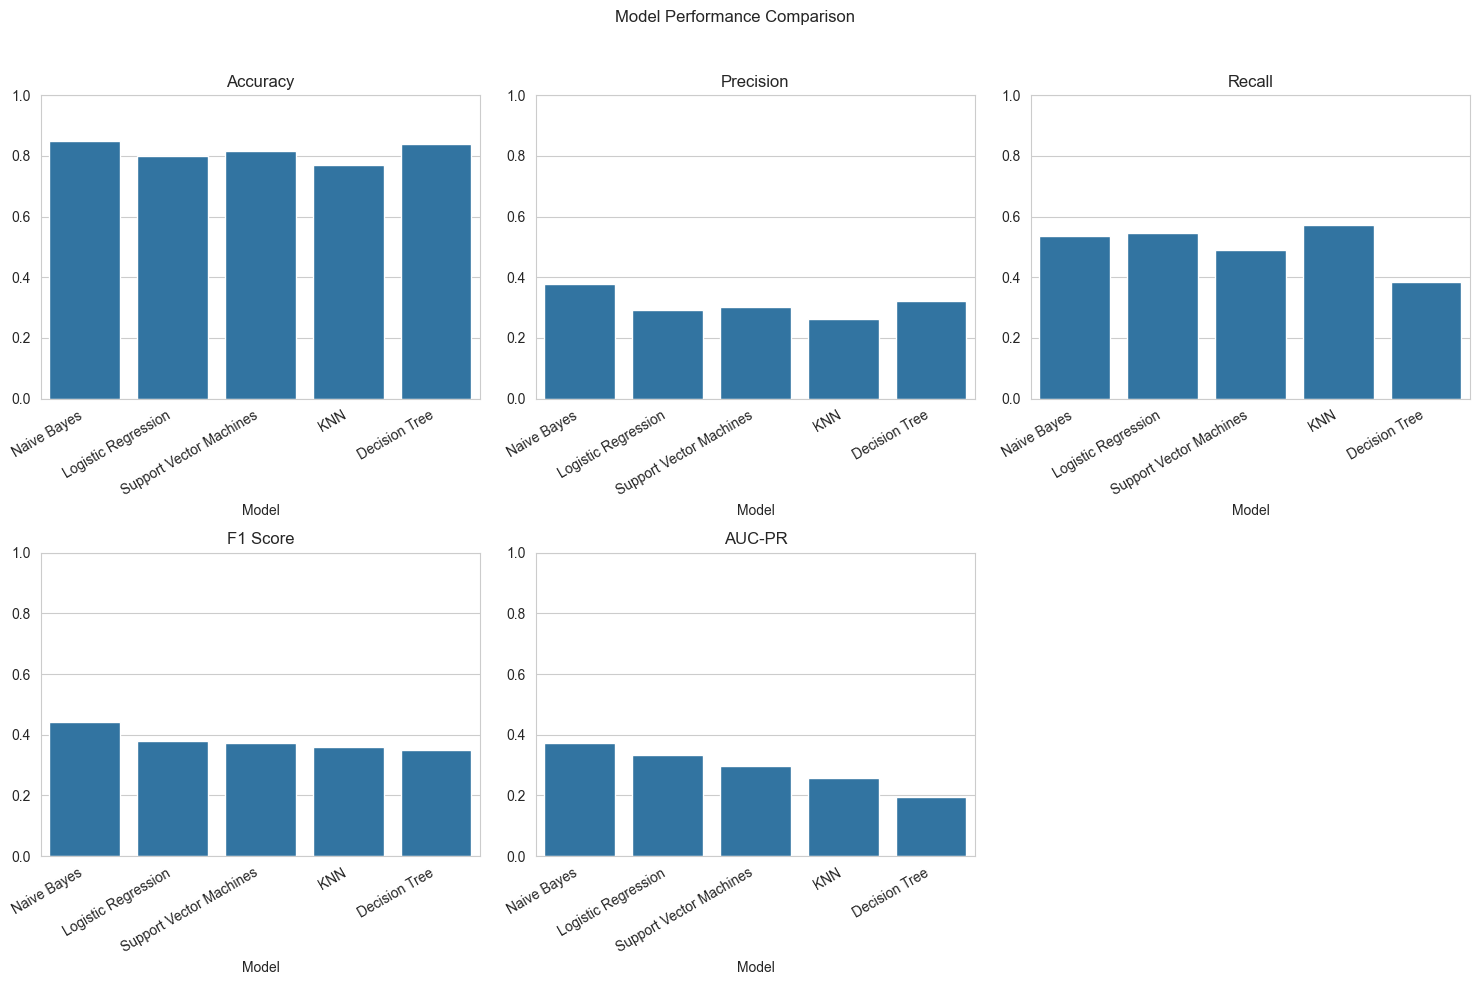

In [72]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-PR']

plt.figure(figsize=(15, 10))
plt.suptitle('Model Performance Comparison')
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=results_df, x='Model', y=metric)
    plt.title(metric)
    plt.ylabel('')
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha='right')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Based on the summary table and bar plots we can say that Naive Bayes achieved the best overall performance, with the highest accuracy (0.85), F1 score (0.44), precision (0.38), and AUC-PR (0.37), indicating that it balances recall and precision better than other models. It also trains very quickly, which adds to its practicality.

Logistic Regression performed similarly well, with F1 equals to 0.38 and AUC-PR of 0.33, confirming that it is also suitable for this classification problem.

Support Vector Machine (SVM) achieved a slightly lower AUC-PR of 0.30, with a precision of 0.30, recall of 0.49, and an F1 score of 0.37. However, it is important to note that this model had a significantly longer training time, making it more computationally demanding and less practical for frequent use.

KNN achieved the highest recall (0.57) of all models, but low precision (0.26) and F1 score (0.36), indicating a tendency to generate many false positives. Moreover, its AUC-PR (0.26) was lower compared to other models. On the other hand, KNN had the shortest training time, which can be considered a key advantage.

Finally, the Decision Tree model achieved similar recall, precision, and F1 score values to the other algorithms, but its AUC-PR (0.196) was the lowest overall. It confirms that this model struggles the most with distinguishing the positive class in an imbalanced dataset.

Overall, Naive Bayes and Logistic Regression stand out as the best performing baseline models in terms of both predictive power and computational efficiency. However, it's worth noting that there aren't significant differences between the models. Most of them achieved values ​​around 0.3-0.4 for the main metric, indicating there's significant room for improvement.

### 4.4 Hyperparameter Tuning for Baseline models
The next step of the analysis is to tune the hyperparameters of the selected models based on the evaluation of their baseline versions in section 4.3. Two optimization methods will be used for this purpose:

- GridSearchCV – systematically tests all possible combinations of predefined hyperparameter values to find the optimal set that maximizes model performance.

- RandomizedSearchCV – randomly samples combinations of hyperparameters from a specified distribution, allowing for faster exploration of the search space with reduced computational cost.

This approach will allow us to identify parameter settings that improve the models’ generalization ability and performance metrics.

Regarding the models selected for tuning, we decided to include Logistic Regression, which achieved the second-highest AUC-PR score in the comparison, and KNN. Naive Bayes, despite ranking first in AUC-PR, was excluded due to its simplicity and limited tuning options, which make hyperparameter optimization less meaningful. Similarly, we decided against SVM because of its very long training time and high computational cost. Additionally, despite its average baseline results, the Decision Tree model will also be tuned, as it often benefits significantly from parameter optimization (eg., adjusting tree depth and splitting criteria).

#### Logistic Regression

The first step in the optimization process is understanding the algorithm's parameters. Therefore, we will first analyze all available parameters.

In [73]:
print(lr_basic.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


For Logistic Regression, hyperparameter optimization was performed using RandomizedSearchCV. This approach allows efficient exploration of the parameter space by sampling random combinations instead of testing every possible configuration, as in GridSearchCV. This method was chosen due to the larger number of parameters to optimize, which makes a full Grid Search computationally expensive.

In [74]:
param_lr = {
    'model__penalty': ['l1', 'l2'],
    'model__C': np.logspace(-3, 3, 10),
    'model__solver': ['saga'],
    'model__max_iter': [5000, 10000]
}

The tuning process was performed using a pipeline that included feature scaling with StandardScaler and handling class imbalance with SMOTETomek. This approach was necessary because performing resampling before cross-validation could lead to data leakage - each fold needs to independently balance the training data to ensure fair evaluation. The optimization focused on parameters such as the regularization type (penalty), regularization strength (C), solver, and maximum number of iterations. The model was evaluated using 5-fold cross-validation, with average precision (AUC-PR) used as the scoring metric to better reflect performance on the imbalanced dataset.

In [75]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTETomek(random_state=42)),
    ('model', LogisticRegression(random_state=42))
])

lr_rs = RandomizedSearchCV(pipe_lr, param_lr, n_iter=20, cv=5, scoring='average_precision', random_state=42, n_jobs=-1)

start_time_lr_rs = time.time()
lr_rs.fit(X_train_imb, y_train_imb)
train_time_lr_rs = time.time() - start_time_lr_rs

best_lr = lr_rs.best_estimator_
print("Best params:", lr_rs.best_params_)
print("Best AUC-PR:", lr_rs.best_score_)

Best params: {'model__solver': 'saga', 'model__penalty': 'l1', 'model__max_iter': 5000, 'model__C': np.float64(0.1)}
Best AUC-PR: 0.43814109871802326


Accuracy:  0.8209574067093856
Recall:  0.6555183946488294
Precision:  0.34507042253521125
F1 score:  0.45213379469434833
Confusion matrix:



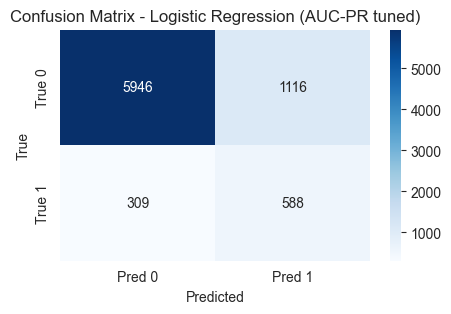

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.802
Area Under Precision-Recall Curve (AUC-PR): 0.475


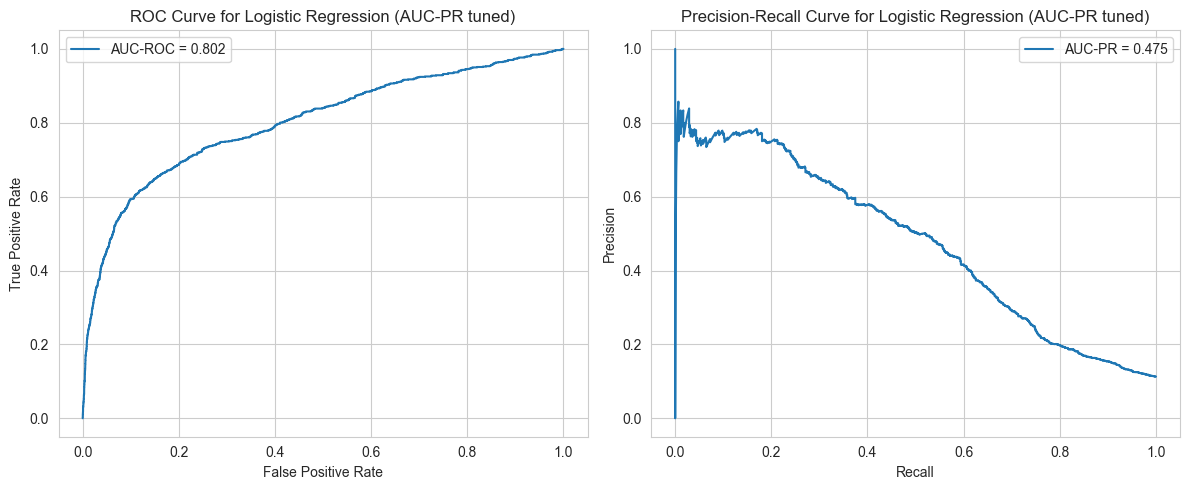

In [76]:
start_pred_lr_rs = time.time()
y_pred_best_lr = best_lr.predict(X_test_model)
y_proba_best_lr = best_lr.predict_proba(X_test_model)[:, 1]
pred_time_lr_rs = time.time() - start_pred_lr_rs

evaluation("Logistic Regression (AUC-PR tuned)", y_pred_best_lr, y_proba_best_lr, train_time_lr_rs, pred_time_lr_rs)

After tuning the logistic regression model, there is a noticeable improvement in its performance compared to the baseline version.After tuning the logistic regression model, a noticeable improvement in its performance compared to the baseline can be seen. The first significant difference is seen in the recall, which increased from 0.55 to 0.66, meaning the model can now correctly identify approximately 2/3 of actual subscribers, reducing the number of false negatives from 408 to 309. The precision also slightly improved to 0.35.Consequently, the F1 score increased to 0.45, confirming the overall improvement in predictive ability.

The AUC-PR value also increased significantly. Compared to the previous value of 0.335, it is now 0.475, which represents a clear improvement. This indicates that the model now performs much better on the imbalanced dataset, more effectively distinguishing positive cases. Similarly, the AUC-ROC increased to 0.80, indicating higher overall discriminatory power. The confusion matrix supports these conclusions: the number of true positives increased, while both false negatives and false positives decreased compared to the baseline.

Overall, the tuned Logistic Regression model shows clear improvement over the baseline version. Although some trade-off between recall and precision remains, the results indicate that the model is starting to resemble a reasonably good classifier, especially considering the challenges posed by the imbalanced dataset.

#### KNN

In [77]:
print(knn_basic.get_params().keys())

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])


For the K-Nearest Neighbors (KNN) model, we used GridSearchCV because it performs a thorough search of all parameter combinations, which is suitable for models with few key hyperparameters. The algorithm was applied to tune the hyperparameters within a pipeline that included feature scaling (StandardScaler) and class balancing using SMOTETomek to avoid bias toward the majority class.

In [78]:
param_knn = {
    'model__n_neighbors': [3, 5, 10, 15, 20, 50],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}

The selected hyperparameters were chosen to explore key aspects of the KNN model’s behavior:

- n_neighbors - controls how many nearby points influence the prediction

- weights - tests whether closer neighbors should have more influence on the prediction

- metric - euclidean, manhattan -  allows comparison between different distance measures



In [79]:
knn_pipe =Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTETomek(random_state=42)),
    ('model', KNeighborsClassifier())
])

knn_gs = GridSearchCV(knn_pipe, param_knn, cv=5,  scoring='average_precision')
start_time_knn_gs = time.time()
knn_gs_fit = knn_gs.fit(X_train_imb, y_train_imb)
train_time_knn_gs = time.time() - start_time_knn_gs
knn_best = knn_gs.best_estimator_

print("The best parameters:", knn_gs.best_params_)
print(f"The best AUC-PR: {knn_gs.best_score_:.4f}")


The best parameters: {'model__metric': 'manhattan', 'model__n_neighbors': 50, 'model__weights': 'uniform'}
The best AUC-PR: 0.4022


The models were evaluated using 5-fold cross-validation with average precision (AUC-PR) as the scoring metric. The best configuration used the Manhattan distance, 50 neighbors, and uniform weights, achieving an AUC-PR of 0.402.

Accuracy:  0.8050006282196256
Recall:  0.6599777034559643
Precision:  0.3219140837411637
F1 score:  0.4327485380116959
Confusion matrix:



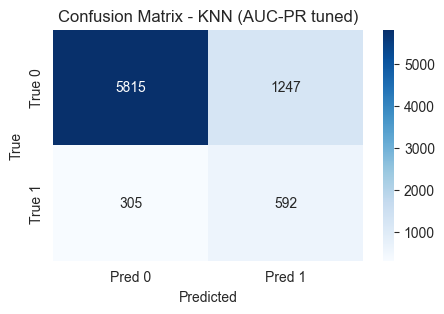

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.783
Area Under Precision-Recall Curve (AUC-PR): 0.413


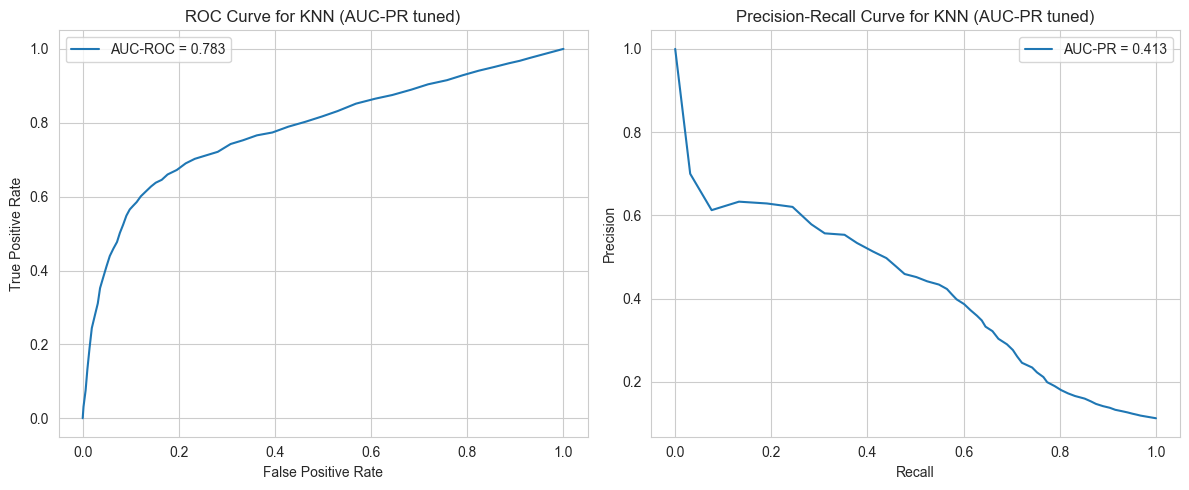

In [80]:
start_pred_knn_gs = time.time()
y_pred_best = knn_best.predict(X_test_model)
y_proba_best = knn_best.predict_proba(X_test_model)[:, 1]
pred_time_knn_gs = time.time() - start_pred_knn_gs

evaluation("KNN (AUC-PR tuned)", y_pred_best, y_proba_best, train_time_knn_gs, pred_time_knn_gs)

The optimized K-Nearest Neighbors (KNN) model achieved an accuracy of 0.81, recall of 0.66, and precision of 0.32, resulting in an F1 score of 0.43. In comparision the baseline model achived an accuracy of 0.81, recall of 0.66, and precision of 0.32, resulting in an F1 score of 0.43. These results show a clear improvement in recall, which means the model is now able to correctly identify a higher proportion of positive cases but at the expense of precision.

The AUC-PR value of 0.413 confirms that the model performs reasonably well in distinguishing the minority class, especially considering the dataset’s imbalance. The Precision-Recall curve shows a steep decline in precision as recall increases. It indicates that the model tries to capture more positive cases, it becomes less precise.

After tuning, the KNN model demonstrates a better balance between recall and precision. The AUC-PR significantly increased from 0.26 to 0.41 compared to the baseline model. This confirms that the number of neighbors (k) has a significant impact on model performance. Although its main evaluation metric is slightly lower compared to the tuned logistic regression model, KNN remains an attractive option due to its simplicity, interpretability, and relatively high performance on an unbalanced dataset.


#### Decision Tree


In [81]:
print(tree_basic.get_params().keys())

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])


As mentioned above, although Decision Tree performed the worst among all models, we decided to attempt to fine-tune it because it often benefits significantly from parameter optimization. For this model, we chose to use RandomizedSearchCV to efficiently and quickly explore a wide range of hyperparameter combinations. The process included the max_depth, min_samples_split, and min_samples_leaf parameters, which control model complexity and help prevent overfitting. The search was implemented in a pipeline that also utilized SMOTETomek to handle class imbalance.

In [82]:
param_tree= {
    'model__max_depth': randint(1, 20),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 20)
}

The selected hyperparameters were chosen:

- max_depth - controls how deep the tree can grow, limiting model complexity and helping prevent overfitting

- min_samples_split - defines the minimum number of samples required to split an internal node

- min_samples_leaf - sets the minimum number of samples required to be at a leaf node

In [83]:
tree_pipe = Pipeline([
    ('smote', SMOTETomek(random_state=42)),
    ('model', DecisionTreeClassifier(random_state=42))
])

tree_rs = RandomizedSearchCV(tree_pipe, param_tree, n_iter=20, cv=5, scoring='average_precision', random_state=42, n_jobs=-1)

start_time_tree_rs = time.time()
tree_rs.fit(X_train_imb, y_train_imb)
train_time_tree_rs = time.time() - start_time_tree_rs

best_tree = tree_rs.best_estimator_
print("Best params:", tree_rs.best_params_)
print("Best AUC-PR:", tree_rs.best_score_)

Best params: {'model__max_depth': 6, 'model__min_samples_leaf': 10, 'model__min_samples_split': 5}
Best AUC-PR: 0.38612260318164726


Accuracy:  0.8154290740042719
Recall:  0.620958751393534
Precision:  0.330367734282325
F1 score:  0.43128145567169957
Confusion matrix:



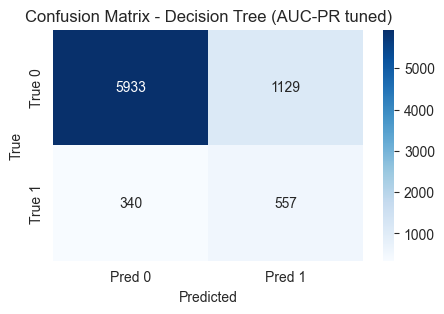

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.773
Area Under Precision-Recall Curve (AUC-PR): 0.405


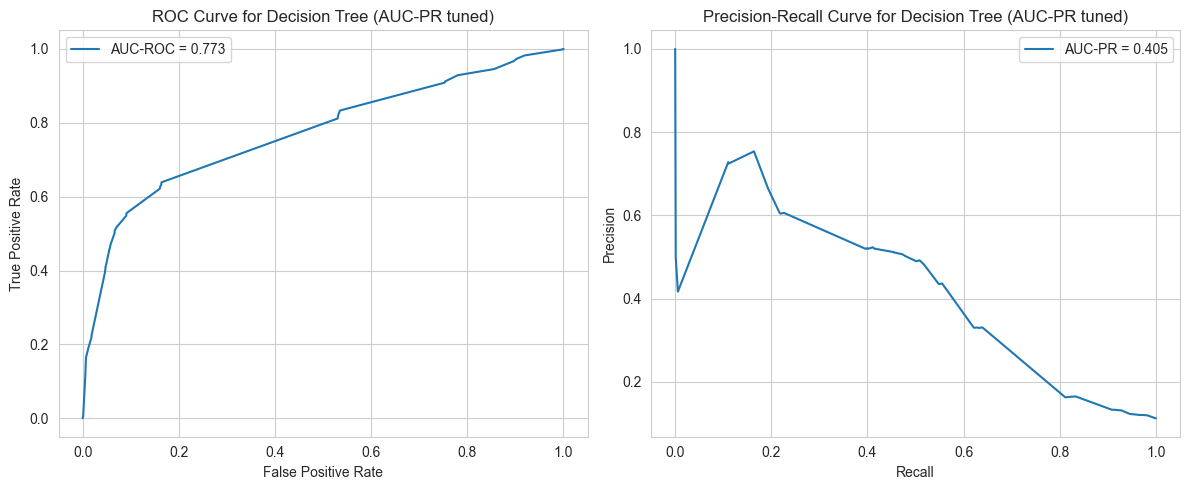

In [84]:
start_pred_tree_rs = time.time()
y_pred_best_tree = best_tree.predict(X_test_model)
y_proba_best_tree = best_tree.predict_proba(X_test_model)[:, 1]
pred_time_tree_rs = time.time() - start_pred_tree_rs

evaluation("Decision Tree (AUC-PR tuned)", y_pred_best_tree, y_proba_best_tree, train_time_tree_rs, pred_time_tree_rs)

After tuning, the Decision Tree model shows a large improvement compared to its baseline version. The AUC-PR increased to 0.405 (previously it reached 0.19), indicating that the model became much better at identifying positive cases in an imbalanced dataset. The model achieved a recall of 0.62 and precision of 0.33, suggesting it is more effective at capturing positive cases but still tends to produce some false positives As with other models, the precision-recall curve reveals a moderate trade-off, meaning that as sensitivity increases, precision decreases.

Overall, this fine-tuned decision tree now performs comparable to KNN and Logistic Regression in terms of AUC-PR. Despite the improvement after tuning, the Decision Tree model still has some limitations. It remains prone to overfitting, especially with deeper trees, which can reduce its generalization performance on unseen data. Additionally, its performance (AUC-PR = 0.405) still lags slightly behind Logistic Regression, suggesting that the model may struggle to capture complex nonlinear relationships effectively.

### 4.5 Ensemble Methods

#### Random Forest

Random Forest is an ensemble machine learning algorithm that uses multiple decision trees to classify data. It works by aggregating the predictions of many trees trained on random subsets of data and features, which helps reduce overfitting and improve generalization. It often provides strong baseline performance and handles class imbalance  more effectively than a single Decision Tree. In this case, we decided to use the default hyperparameters of the Random Forest model. This choice was made because the algorithm is generally robust and performs well even without extensive tuning.

In [85]:
# Default values: n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1
forest_basic = RandomForestClassifier(random_state=42)

start_train_forest = time.time()
forest_basic.fit(X_train_model, y_train_model)
train_time_forest= time.time() - start_train_forest

start_pred_forest = time.time()
pred_forest = forest_basic.predict(X_test_model)
y_proba_forest = forest_basic.predict_proba(X_test_model)[:, 1]
pred_time_forest = time.time() - start_pred_forest

Accuracy:  0.8800100515140094
Recall:  0.43032329988851725
Precision:  0.4650602409638554
F1 score:  0.4470179502026636
Confusion matrix:



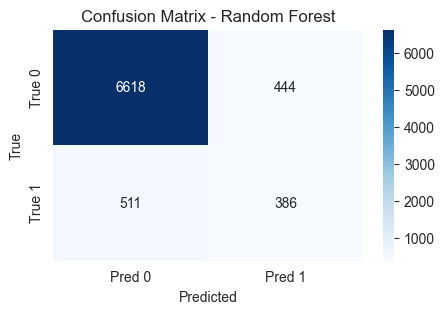

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.776
Area Under Precision-Recall Curve (AUC-PR): 0.393


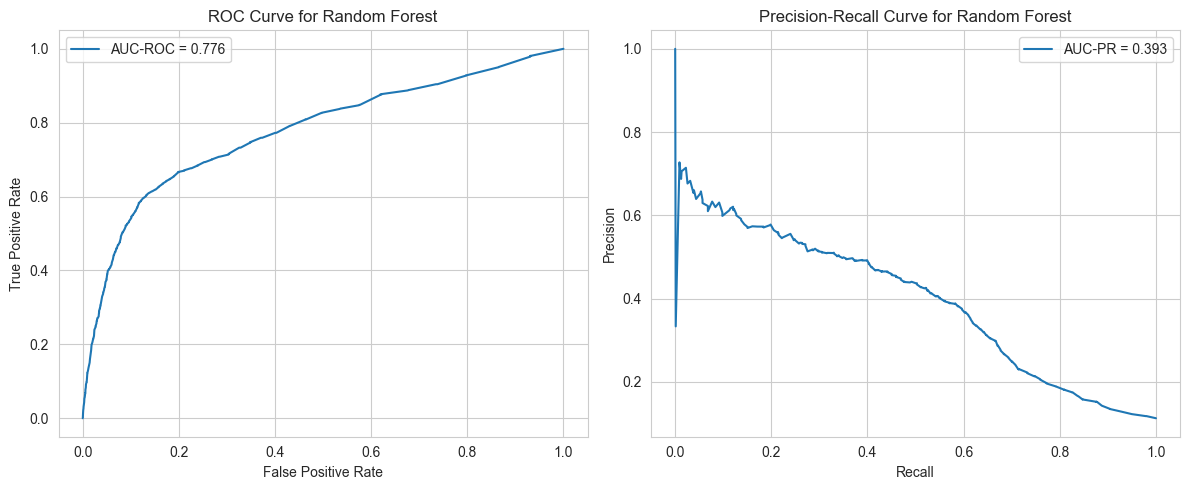

                          Feature  Importance
10                      euribor3m    0.170881
0                             age    0.123228
3                        campaign    0.115833
11                    nr.employed    0.071085
7                    emp.var.rate    0.042004
9                   cons.conf.idx    0.035589
8                  cons.price.idx    0.028543
30              contact_telephone    0.028072
1                         housing    0.022037
4                           pdays    0.019563
22                marital_married    0.018520
40                day_of_week_mon    0.017918
12                job_blue-collar    0.016799
43                day_of_week_wed    0.016086
28    education_university.degree    0.016025
2                            loan    0.016008
29                     default_no    0.015975
6                        previous    0.015738
41                day_of_week_thu    0.015398
26          education_high.school    0.015034
23                 marital_single 

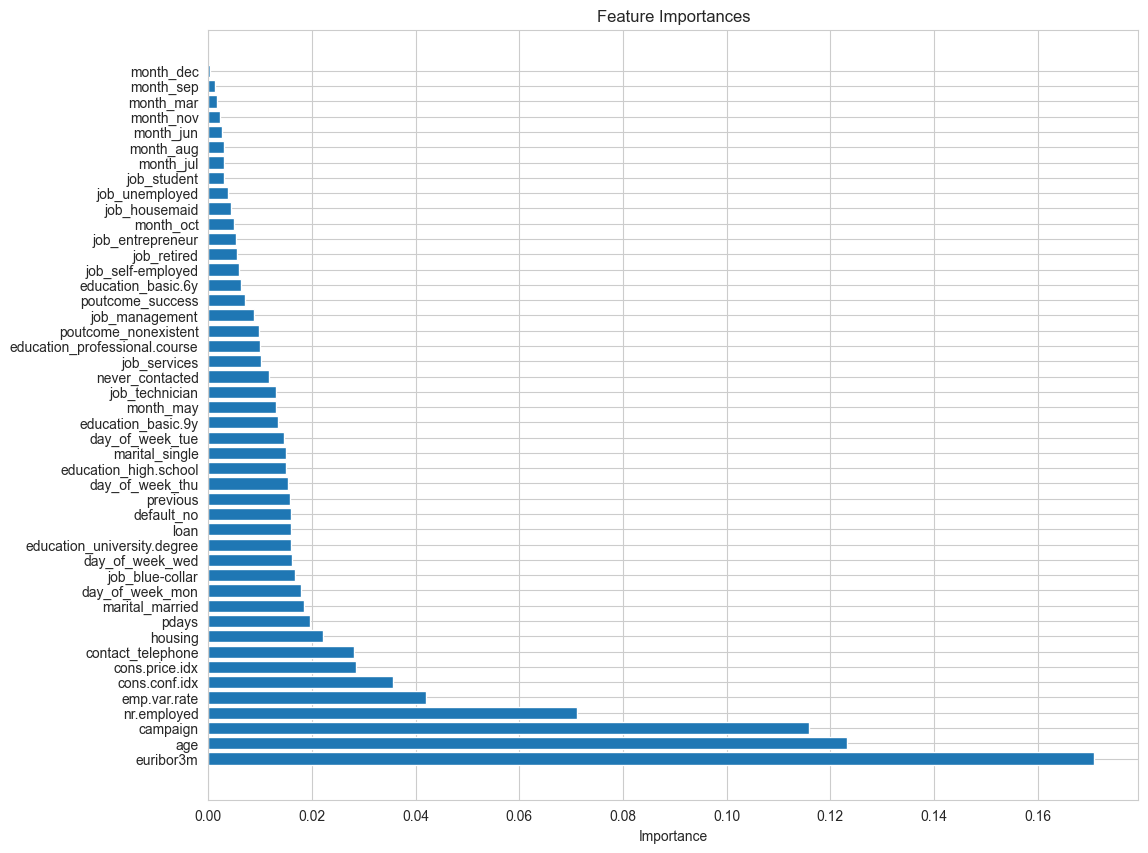

In [86]:
evaluation("Random Forest", pred_forest, y_proba_forest, train_time_forest, pred_time_forest)
feature_names = X_train_model.columns
importances = forest_basic.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

The Random Forest model achieved an accuracy of 0.88, which is one of the highest value among all tested models. The recall equal to 0.43 indicates that the model misses more than half of the positive cases The value of precision is very similar and equal to  0.46. The F1-score 0.45 confirms a moderate balance between these two metrics. Based on the confusion matrix, we can see a high number of false negatives (511), which means many potential subscribers were not identified. This type of error can be more critical in the context of our problem, as failing to recognize interested customers could result in lost business opportunities. In contrast, false positives (identifying customers who would not subscribe) would only lead to unnecessary additional contact, which is less costly. AUC-PR achieved a value of 0.393, which is relatively low for an ensemble model like Random Forest. However, this can be partly explained by the imbalanced nature of the dataset, which makes it difficult for the model to maintain high precision while identifying the minority class. Overall, Random Forest performs competitively even with default hyperparameters, benefiting from its ensemble nature that reduces overfitting.

The most important features identified by the Random Forest model are:
- euribor3m - the 3-month Euribor rate (daily indicator)
- age - customer’s age,
- campaign - number of contacts performed during this campaign and for this client
- nr.employed - number of employees (quarterly indicator).


#### Gradient Boosting

Gradient boosting is a machine learning technique that combines multiple weak prediction models into a single ensemble. These weak models are typically decision trees, which are trained sequentially to minimize errors and improve accuracy. This approach allows the method to iteratively optimize performance, often achieving high accuracy even on complex datasets. However, it comes with longer training times and a higher risk of overfitting if the method is not properly regularized. In this case, the model was trained using default hyperparameters (learning_rate=0.1, n_estimators=100, subsample=1.0, max_depth=3, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1).

In [87]:
# Default values: learning_rate=0.1, n_estimators=100, subsample=1.0, max_depth=3, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1
gb_basic = GradientBoostingClassifier(random_state=42)

start_train_gb = time.time()
gb_basic.fit(X_train_model, y_train_model)
train_time_gb= time.time() - start_train_gb

start_pred_gb = time.time()
pred_gb = gb_basic.predict(X_test_model)
y_proba_gb = gb_basic.predict_proba(X_test_model)[:, 1]
pred_time_gb = time.time() - start_pred_gb

Accuracy:  0.8728483477823847
Recall:  0.5451505016722408
Precision:  0.4473924977127173
F1 score:  0.4914572864321608
Confusion matrix:



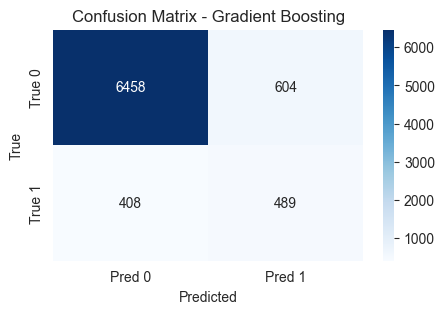

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.787
Area Under Precision-Recall Curve (AUC-PR): 0.437


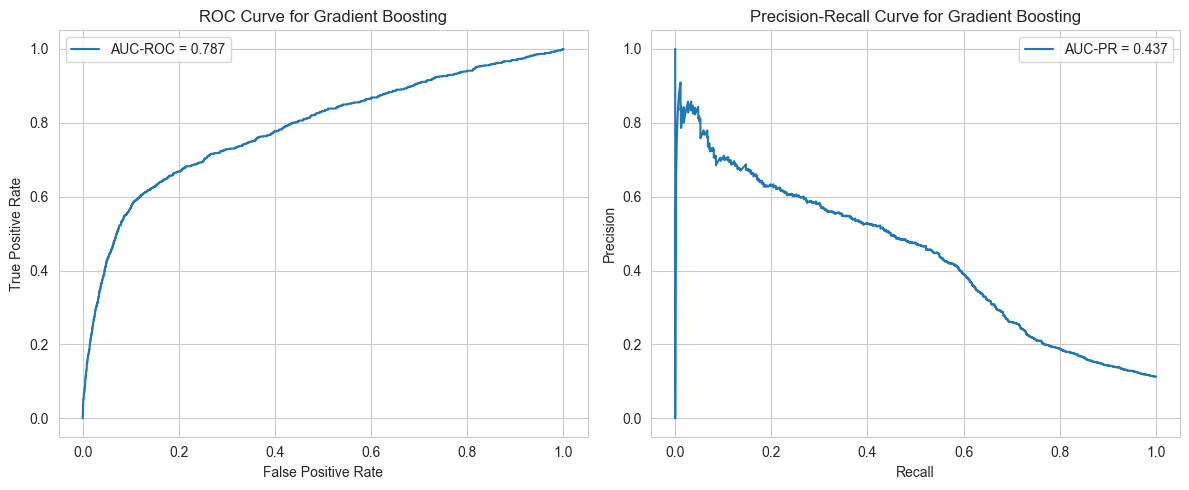

                          Feature  Importance
3                        campaign    0.294021
11                    nr.employed    0.232994
10                      euribor3m    0.168821
9                   cons.conf.idx    0.066451
30              contact_telephone    0.034243
40                day_of_week_mon    0.017162
36                      month_may    0.016002
2                            loan    0.014810
8                  cons.price.idx    0.013084
12                job_blue-collar    0.011925
38                      month_oct    0.011500
42                day_of_week_tue    0.010908
41                day_of_week_thu    0.010815
4                           pdays    0.010593
20                 job_technician    0.009760
7                    emp.var.rate    0.008515
43                day_of_week_wed    0.006172
18                   job_services    0.006123
5                 never_contacted    0.005935
1                         housing    0.005877
15                 job_management 

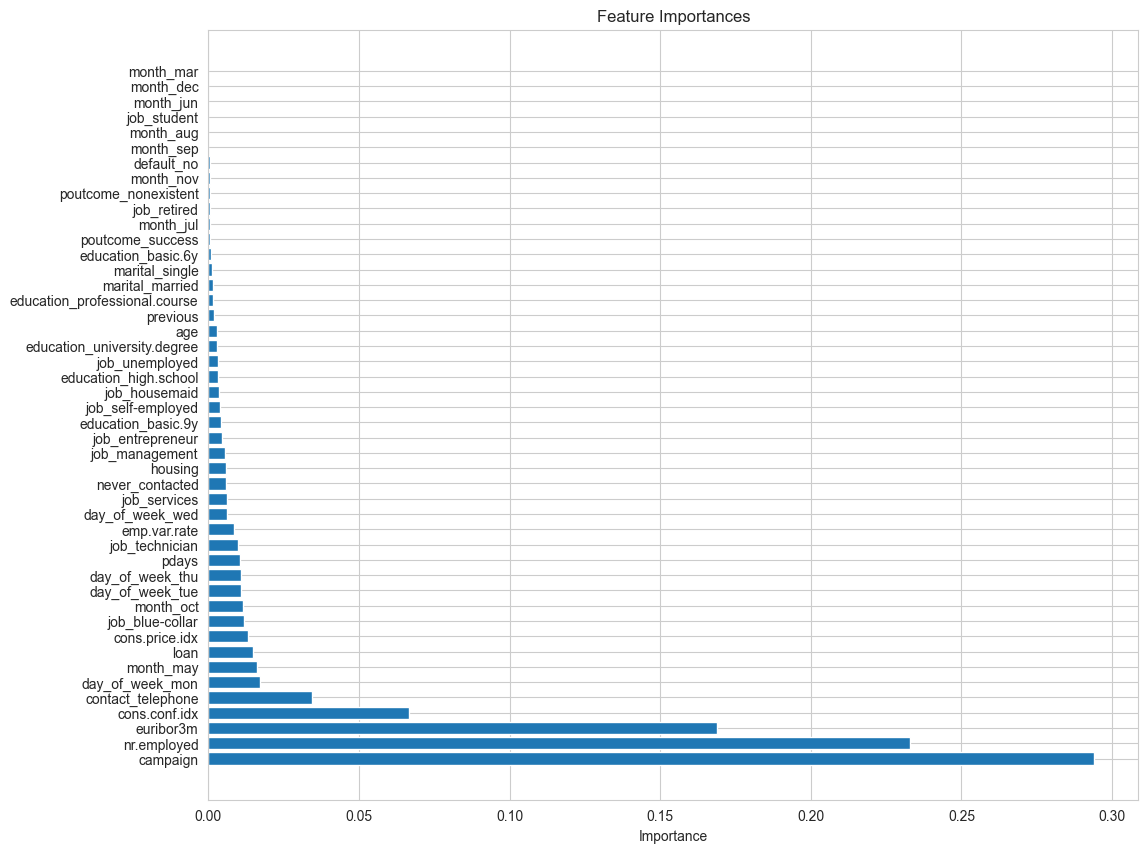

In [88]:
evaluation("Gradient Boosting", pred_gb, y_proba_gb, train_time_gb, pred_time_gb)
feature_names = X_train_model.columns
importances = gb_basic.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

The Gradient Boosting model achieved an accuracy of 0.87, with a recall of 0.55 and precision of 0.45. This means the model identifies over half of the positive cases while maintaining a relatively good balance between recall and precision, especially compared to simpler models such as the Decision Tree. The F1-score of 0.49 further confirms this balance. The confusion matrix shows that the model correctly classifies the majority of negative cases (6458), while still identifying a fair number of true positives (489). However, some false negatives (408) remain, suggesting potential room for improvement.
The AUC-PR value of 0.437 indicates that the model performs reasonably well in handling the imbalanced dataset, showing its ability to capture meaningful patterns even without hyperparameter tuning.

The most important features identified by the Gradient Boosting model are:

- campaign - number of contacts performed during this campaign and for this client

- nr.employed - number of employees (quarterly indicator)

- euribor3m -  the 3-month Euribor rate (daily indicator)


#### Bagging Classifier

Bagging (Bootstrap Aggregating) is an ensemble technique that aims to reduce variance and improve stability. It works by training many independent models (in this case, decision trees) on different random subsets of the data. The final prediction is made by taking a majority vote from all the individual models. The goal is to create a robust "wisdom of the crowd" effect, making the final model less prone to overfitting than a single tree.

In [89]:
from sklearn.ensemble import BaggingClassifier

base_estimator = DecisionTreeClassifier(class_weight='balanced', random_state=42)

bagging_model = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=50,
    max_samples=0.8,
    max_features=0.8,
    random_state=42,
    n_jobs=-1
)

print("Training the Bagging Classifier...")
start_train_bagging = time.time()
bagging_model.fit(X_train_model, y_train_model)
train_time_bagging= time.time() - start_train_bagging


start_pred_bagging = time.time()
y_pred_bagging = bagging_model.predict(X_test_model)
y_proba_bagging  = bagging_model.predict_proba(X_test_model)[:, 1]
pred_time_bagging = time.time() - start_pred_bagging

accuracy = accuracy_score(y_test_model, y_pred_bagging)
print(f"\nModel Accuracy: {accuracy:.4f}")


Training the Bagging Classifier...

Model Accuracy: 0.8894


Accuracy:  0.8894333458977258
Recall:  0.4124860646599777
Precision:  0.5117565698478561
F1 score:  0.4567901234567901
Confusion matrix:



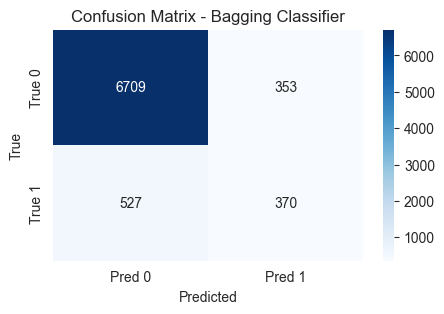

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.777
Area Under Precision-Recall Curve (AUC-PR): 0.427


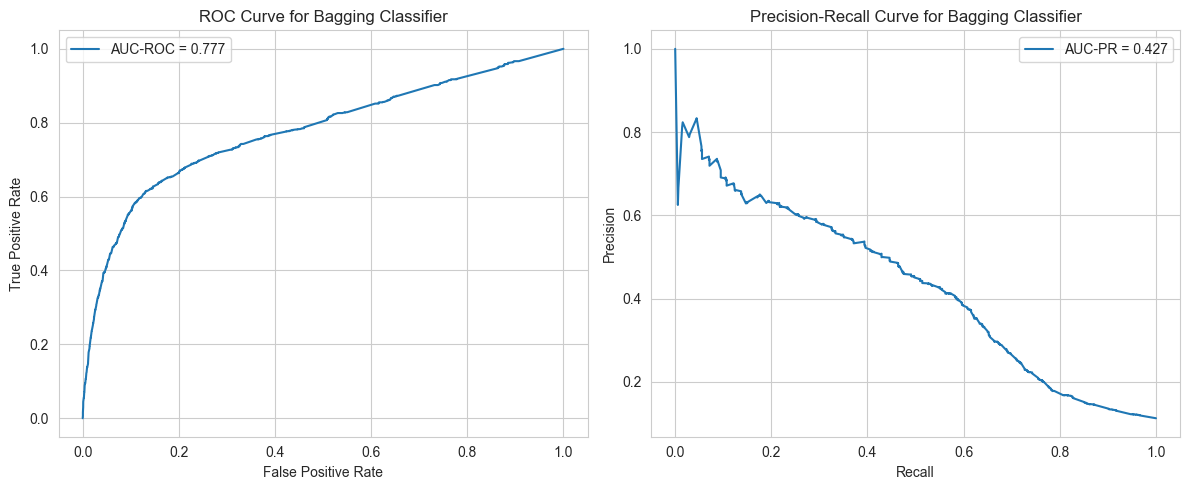

In [90]:
evaluation('Bagging Classifier', y_pred_bagging, y_proba_bagging, train_time_bagging, pred_time_bagging)

### Performance analysis - Bagging Clasifier
The results show a model with overall high accuracy at around 88.7%. However, the main indicators essential for our issue are not so high. When we look ar precision it is below 50%, which means for every client the model identifies as a potential buyer there is equal chance that it's wrong. Recall at 40.6% indicates that the model finds less than half of the actual clients who would be interested in the product. The good thing about this model is that it takes very little time to teach this model. On average around 15 seconds. Which is quite impressive time when we look at the accuracy that we achieved.

#### AdaBoost

AdaBoost (Adaptive Boosting) is a sequential ensemble method. It works by training a series of "weak" models (typically shallow decision trees) one after another. Each new model in the sequence is trained to pay more attention to the data points that the previous models misclassified. This adaptive, mistake-focused process allows AdaBoost to build a strong, highly specialized classifier that focuses on the most challenging aspects of the data.

In [91]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 2]
}

weak_learner = DecisionTreeClassifier(random_state=42)

adaboost_model = AdaBoostClassifier(
    estimator=weak_learner,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=adaboost_model,
    param_grid=param_grid,
    scoring='average_precision',
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("Starting GridSearchCV for AdaBoostClassifier...")
start_train_grid = time.time()
grid_search.fit(X_train_model, y_train_model)
train_time_grid = time.time() - start_train_grid
print(f"GridSearchCV training completed in {train_time_grid:.4f} seconds.")

print("\nBest parameters found:")
print(grid_search.best_params_)

best_adaboost_model = grid_search.best_estimator_

start_pred_adaboost = time.time()
y_pred_adaboost = best_adaboost_model.predict(X_test_model)
y_proba_adaboost = best_adaboost_model.predict_proba(X_test_model)[:, 1]
pred_time_adaboost = time.time() - start_pred_adaboost

print(f"Prediction with the best model completed in {pred_time_adaboost:.4f} seconds.")


accuracy = accuracy_score(y_test_model, y_pred_adaboost)
print(f"\nModel Accuracy: {accuracy:.4f}")

# best recall parameters:
# param_best_recall = {
#     'n_estimators': [50],
#     'learning_rate': [1.0],
#     'estimator__max_depth': [1]
# }

Starting GridSearchCV for AdaBoostClassifier...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
GridSearchCV training completed in 69.8063 seconds.

Best parameters found:
{'estimator__max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 200}
Prediction with the best model completed in 0.3276 seconds.

Model Accuracy: 0.8702


Accuracy:  0.8702098253549441
Recall:  0.5094760312151616
Precision:  0.43523809523809526
F1 score:  0.4694401643554186
Confusion matrix:



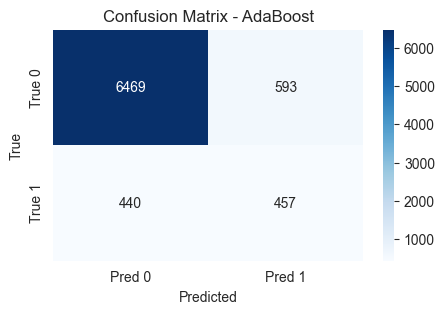

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.770
Area Under Precision-Recall Curve (AUC-PR): 0.413


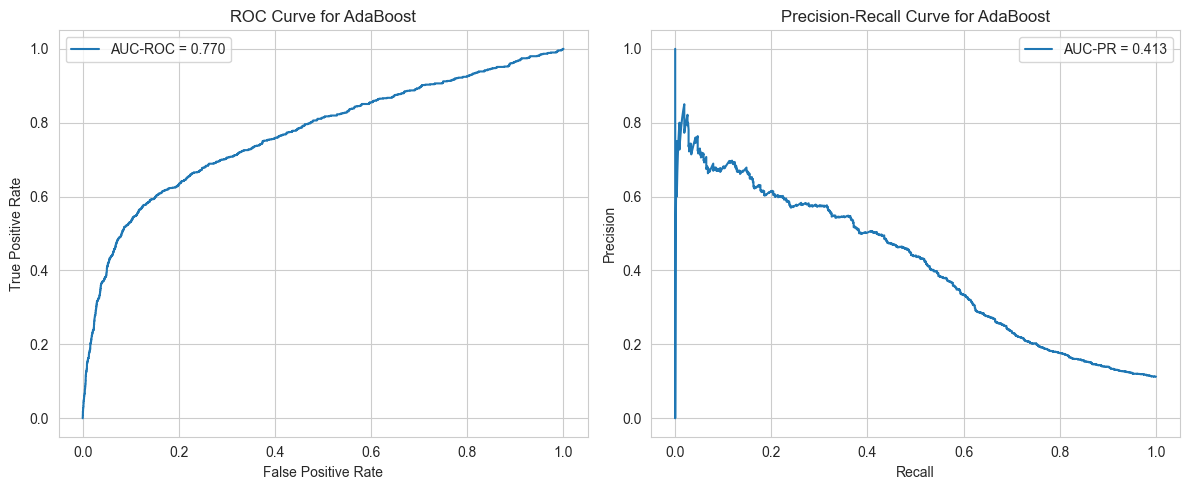

In [92]:
evaluation('AdaBoost', y_pred_adaboost, y_proba_adaboost, train_time_grid, pred_time_adaboost)

### Performance analysis - AdaBoost
Just like the previous model we got very similar accuracy of this model, around 86.7%. However, the precision is much smaller on this one (42.4%) but the recall increased strongly to 48.9%. This means that on this model we got more false positives but also substantially more true positives. It is not perfect but this model would get much more benefit to the company it will use than the bagging classifier.

#### XGBoost

XGBoost (Extreme Gradient Boosting) is a highly advanced and efficient implementation of the gradient boosting algorithm. Like AdaBoost, it builds models sequentially, with each new tree correcting the errors of the previous ones. However, XGBoost is more sophisticated; it uses a more advanced mathematical optimization (gradient descent) and includes built-in regularization to prevent overfitting. This combination of speed, power, and robustness has made it a go-to algorithm for winning data science competitions.

In [94]:
from xgboost import XGBClassifier

count_neg = np.sum(y_train_model == 0)
count_pos = np.sum(y_train_model == 1)
scale_pos_weight = count_neg / count_pos

print(f"Calculated scale_pos_weight for imbalance: {scale_pos_weight:.2f}")

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

print("Training the XGBoost Classifier...")
start_train_xgb = time.time()
xgb_model.fit(X_train_model, y_train_model)
train_time_xgb = time.time() - start_train_xgb

start_pred_xgb = time.time()
y_pred_xgb = xgb_model.predict(X_test_model)
y_proba_xgb = xgb_model.predict_proba(X_test_model)[:, 1]
pred_time_xgb = time.time() - start_pred_xgb

print(f"\nTraining completed in {train_time_xgb:.4f} seconds.")
print(f"Prediction completed in {pred_time_xgb:.4f} seconds.")

accuracy = accuracy_score(y_test_model, y_pred_xgb)
print(f"\nModel Accuracy: {accuracy:.4f}")

Calculated scale_pos_weight for imbalance: 1.00
Training the XGBoost Classifier...

Training completed in 1.7864 seconds.
Prediction completed in 0.0172 seconds.

Model Accuracy: 0.8683


Accuracy:  0.8683251664782008
Recall:  0.5462653288740246
Precision:  0.4332449160035367
F1 score:  0.4832347140039448
Confusion matrix:



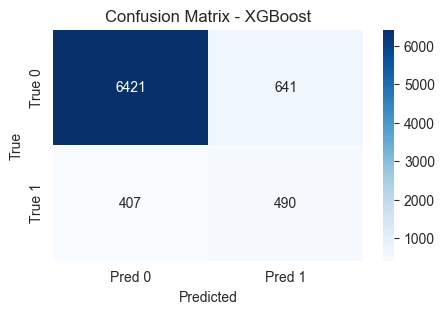

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.784
Area Under Precision-Recall Curve (AUC-PR): 0.434


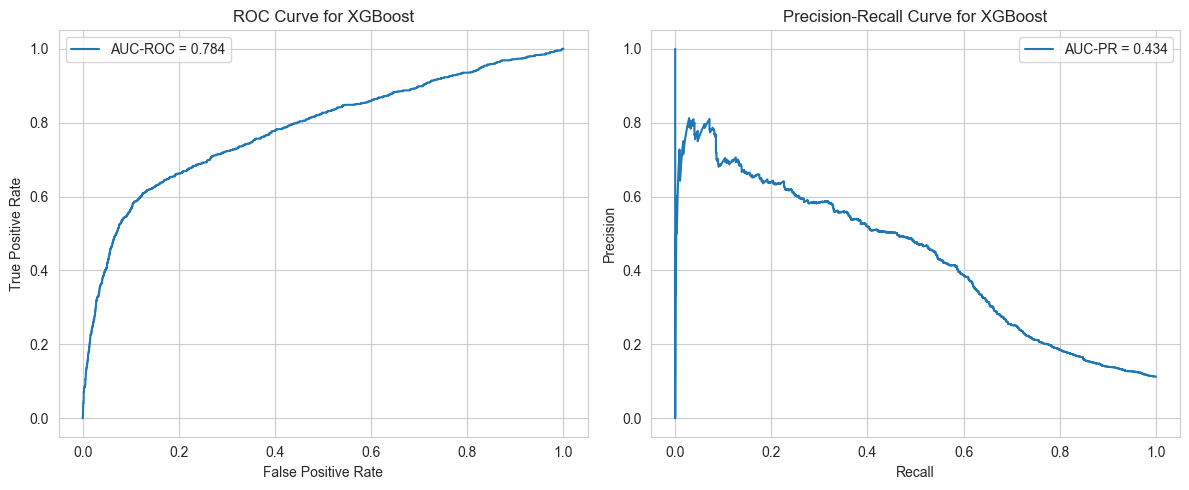

In [95]:
evaluation('XGBoost', y_pred_xgb, y_proba_xgb, train_time_xgb, pred_time_xgb)

### Performance analysis - XGBoost
This highly advanced and efficient implementation of gradient boosting algorithm achieved very good results. Recall is one of the best reaching 54.8%. But we have a trade-off with low precision, very close to the AdaBoost at 44.9%. Strong AUC-PR (0.438) indicates that the model has a better potential to balance precision and recall than the previously analysed models.

#### LightGBM

LightGBM (Light Gradient Boosting Machine) is another advanced gradient boosting framework. Its key characteristic is its leaf-wise tree growth strategy, which allows it to converge much faster and often with better accuracy than other algorithms that grow trees level-by-level. This efficiency makes it a top-tier choice for building powerful models quickly, especially with large datasets.

In [96]:
import lightgbm as lgb

lgbm_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Training the LightGBM Classifier with class_weight='balanced'...")
start_train_lgbm = time.time()
lgbm_model.fit(X_train_model, y_train_model)
train_time_lgbm = time.time() - start_train_lgbm

start_pred_lgbm = time.time()
y_pred_lgbm = lgbm_model.predict(X_test_model)
y_proba_lgbm = lgbm_model.predict_proba(X_test_model)[:, 1]
pred_time_lgbm = time.time() - start_pred_lgbm

print(f"\nTraining completed in {train_time_lgbm:.4f} seconds.")
print(f"Prediction completed in {pred_time_lgbm:.4f} seconds.")

Training the LightGBM Classifier with class_weight='balanced'...
[LightGBM] [Info] Number of positive: 28073, number of negative: 28073
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1886
[LightGBM] [Info] Number of data points in the train set: 56146, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Training completed in 0.6600 seconds.
Prediction completed in 0.0181 seconds.


Accuracy:  0.8949616786028396
Recall:  0.42474916387959866
Precision:  0.543509272467903
F1 score:  0.47684605757196497
Confusion matrix:



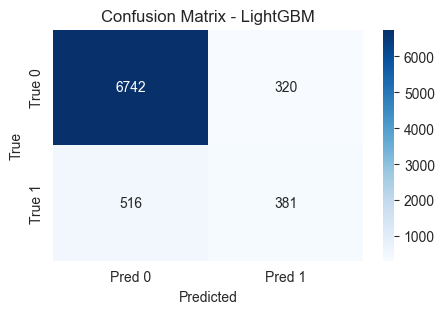

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.790
Area Under Precision-Recall Curve (AUC-PR): 0.447


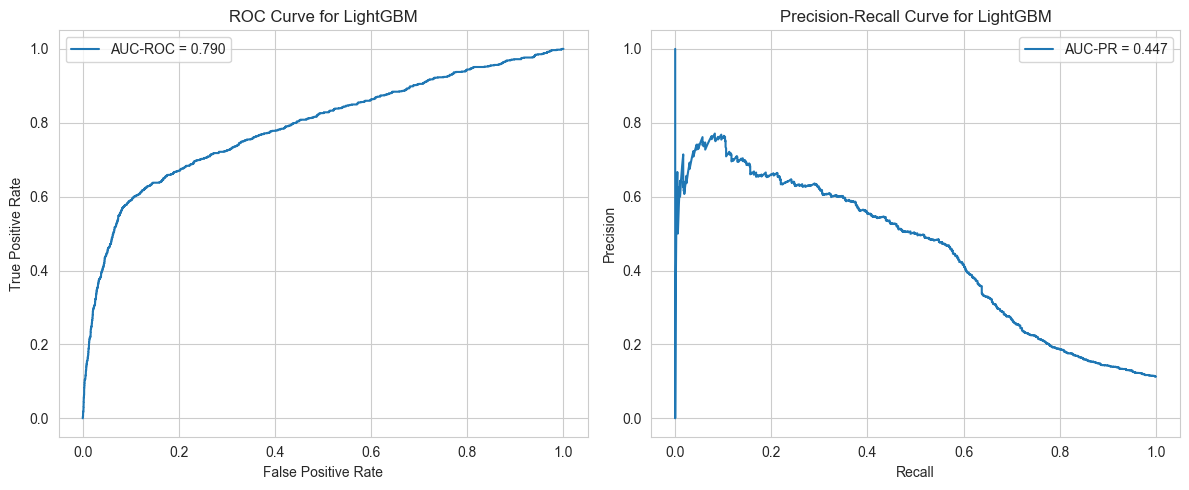

In [97]:
evaluation('LightGBM', y_pred_lgbm, y_proba_lgbm, train_time_lgbm, pred_time_lgbm)

### Performance analysis - LightGBM
This model achieved the highest AUC-PR score out of all ensemble learning methods, reaching 0.445. It is very close to 0.5 score but not here yet. It has a big potential to be fine-tuned. It's extremely fast learning time is outstanding in comparison to its performance. It took only 1.5 second to achieve this kind o results. It got an over average precision, scoring 53.2%. But on the expense of recall which got 43.8%. On the confusion matrix we can see it got much more false negatives.

---
# 5. Neural Networks
### 5.1 Neural Network Architecture

Neural Network, or Multi-Layer Perceptron (MLP), is a highly flexible model inspired by the structure of the human brain. It uses interconnected layers of "neurons" to learn complex, non-linear relationships in the data. By tuning its architecture and learning parameters, it can theoretically model any function, but this complexity can also make it difficult to optimize and prone to poor performance if not configured perfectly.

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

CALCULATE = False

dfNN = df1.copy()

X = dfNN.drop(columns=['y'])
y = dfNN['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
mlp = MLPClassifier(max_iter=1000, random_state=42)

param_grid = {
    'alpha': [0.0001, 0.001, 0.05],
    'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50)],
    'solver': ['sgd', 'adam'],
    'batch_size': [32, 64, 'auto'],
    'max_iter': [500, 1000, 1500],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.0001, 0.01],
}

if CALCULATE:
    grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=5, scoring='average_precision', verbose=2)

    print("Starting Grid Search...")
    grid_search.fit(X_train_model, y_train_model)

    print("\nBest parameters found:")
    print(grid_search.best_params_)

    best_mlp = grid_search.best_estimator_
    y_pred_NN = best_mlp.predict(X_test_model)
    accuracy = accuracy_score(y_test_model, y_pred_NN)
    print(f"\nOptimized Neural Network Accuracy: {accuracy:.4f}")

else:
    best_params_from_grid = {
        'alpha': 0.001,
        'hidden_layer_sizes': (50, ),
        'solver': 'adam',
        'batch_size': 'auto',
        'max_iter': 500,
        'activation': 'tanh',
        'learning_rate_init': 0.0001,
    }

    mlp.set_params(**best_params_from_grid)

    print("Starting Best Params NN...")
    start_train_NN = time.time()
    mlp.fit(X_train_model, y_train_model)
    train_time_NN= time.time() - start_train_NN

    print("\nBest parameters:")
    print(best_params_from_grid)

    start_pred_NN = time.time()
    y_pred_NN = mlp.predict(X_test_model)
    y_proba_NN = mlp.predict_proba(X_test_model)[:, 1]
    pred_time_NN = time.time() - start_pred_NN
    accuracy = accuracy_score(y_test_model, y_pred_NN)
    print(f"\nOptimized Neural Network Accuracy: {accuracy:.4f}")



Starting Best Params NN...

Best parameters:
{'alpha': 0.001, 'hidden_layer_sizes': (50,), 'solver': 'adam', 'batch_size': 'auto', 'max_iter': 500, 'activation': 'tanh', 'learning_rate_init': 0.0001}

Optimized Neural Network Accuracy: 0.8200



Retraining the best model with early stopping to plot history...


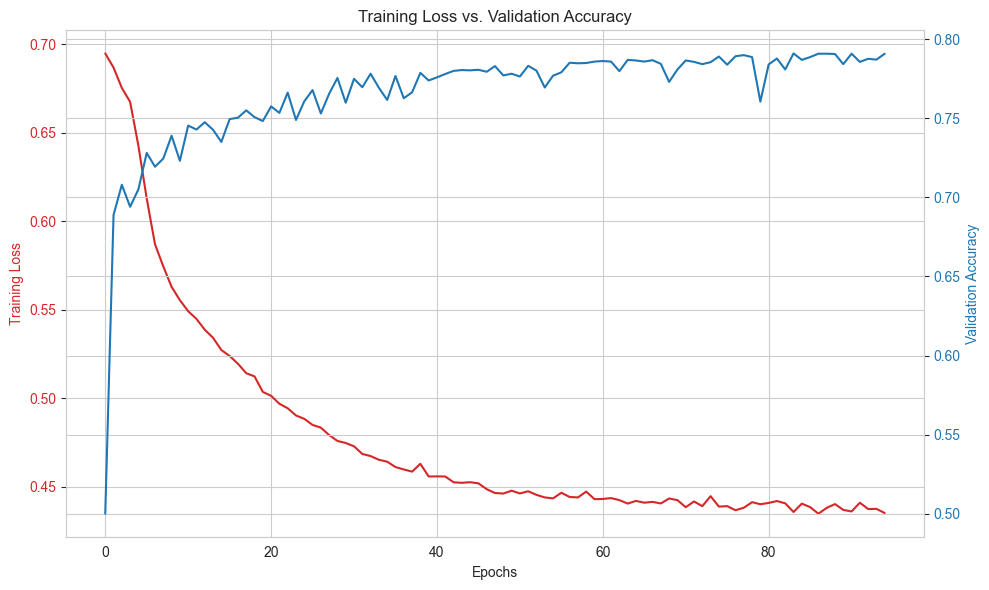

In [99]:
if CALCULATE:
    best_params = grid_search.best_params_
else:
    best_params = best_params_from_grid

best_mlp = MLPClassifier(**best_params,
                         random_state=42,
                         early_stopping=True,
                         verbose=False)

print("\nRetraining the best model with early stopping to plot history...")
best_mlp.fit(X_train_model, y_train_model)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(best_mlp.loss_curve_, color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy', color=color)
ax2.plot(best_mlp.validation_scores_, color=color, label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Loss vs. Validation Accuracy')
fig.tight_layout()
plt.show()

Accuracy:  0.8199522553084558
Recall:  0.5039018952062431
Precision:  0.3138888888888889
F1 score:  0.38682071031236626
Confusion matrix:



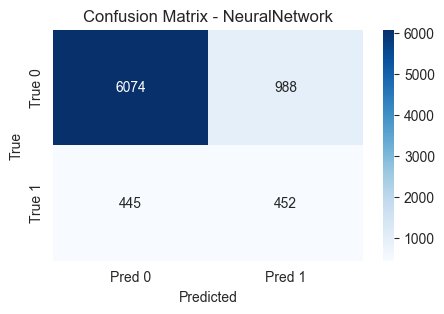

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): 0.749
Area Under Precision-Recall Curve (AUC-PR): 0.355


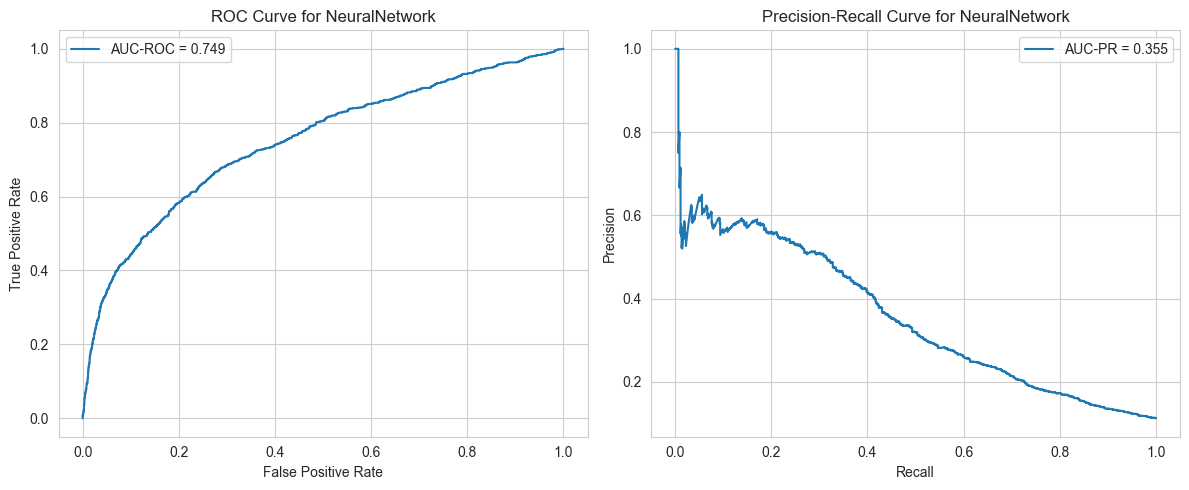

In [100]:
evaluation("NeuralNetwork", y_pred_NN, y_proba_NN, train_time_NN, pred_time_NN)

### Performance analysis - Neural Network
Despite its potential power, the Neural Network's performance was the poorest of all models tested. It struggled significantly to create a useful model for the business objective. Precision is extremely low at 36.2%. It has the worst confusion matrix ratio. The model made 700 false positive errors while only finding 398 true positives. It has the lowest AUC-PR (0.360). Unlike the boosting models which showed promise even with poor default precision, the Neural Network demonstrates a poor trade-off between precision and recall across all possible thresholds. Despite using GridSearch to find the best parameters for this network still it's performance was lacking. We think it may require longer learning and bigger training data sets to achieve better performance.

### Model comparison

In [101]:
results_df = pd.DataFrame(results)
if not results_df.empty:
    results_df = results_df.sort_values(by='AUC-PR', ascending=False).reset_index(drop=True)
results_df

,Model,Training time,Prediction time,Accuracy,Precision,Recall,F1 Score,AUC-ROC,AUC-PR
0,Logistic Regression (AUC-PR tuned),158.437793,0.015860,0.820957,0.345070,0.655518,0.452134,0.801754,0.475305
1,LightGBM,0.659981,0.018086,0.894962,0.543509,0.424749,0.476846,0.789800,0.446850
2,Gradient Boosting,12.691128,0.034809,0.872848,0.447392,0.545151,0.491457,0.786711,0.437221
3,XGBoost,1.786444,0.017157,0.868325,0.433245,0.546265,0.483235,0.783773,0.433894
4,Bagging Classifier,1.327909,0.439467,0.889433,0.511757,0.412486,0.456790,0.776888,0.427307
5,KNN (AUC-PR tuned),277.547176,3.488131,0.805001,0.321914,0.659978,0.432749,0.783431,0.413015
6,AdaBoost,69.806293,0.327615,0.870210,0.435238,0.509476,0.469440,0.769675,0.412667
7,Decision Tree (AUC-PR tuned),96.714987,0.009131,0.815429,0.330368,0.620959,0.431281,0.772968,0.404911
8,Random Forest,8.553452,0.618986,0.880010,0.465060,0.430323,0.447018,0.776339,0.392650
9,Naive Bayes,0.033969,0.014551,0.848348,0.377953,0.535117,0.443009,0.754852,0.372059


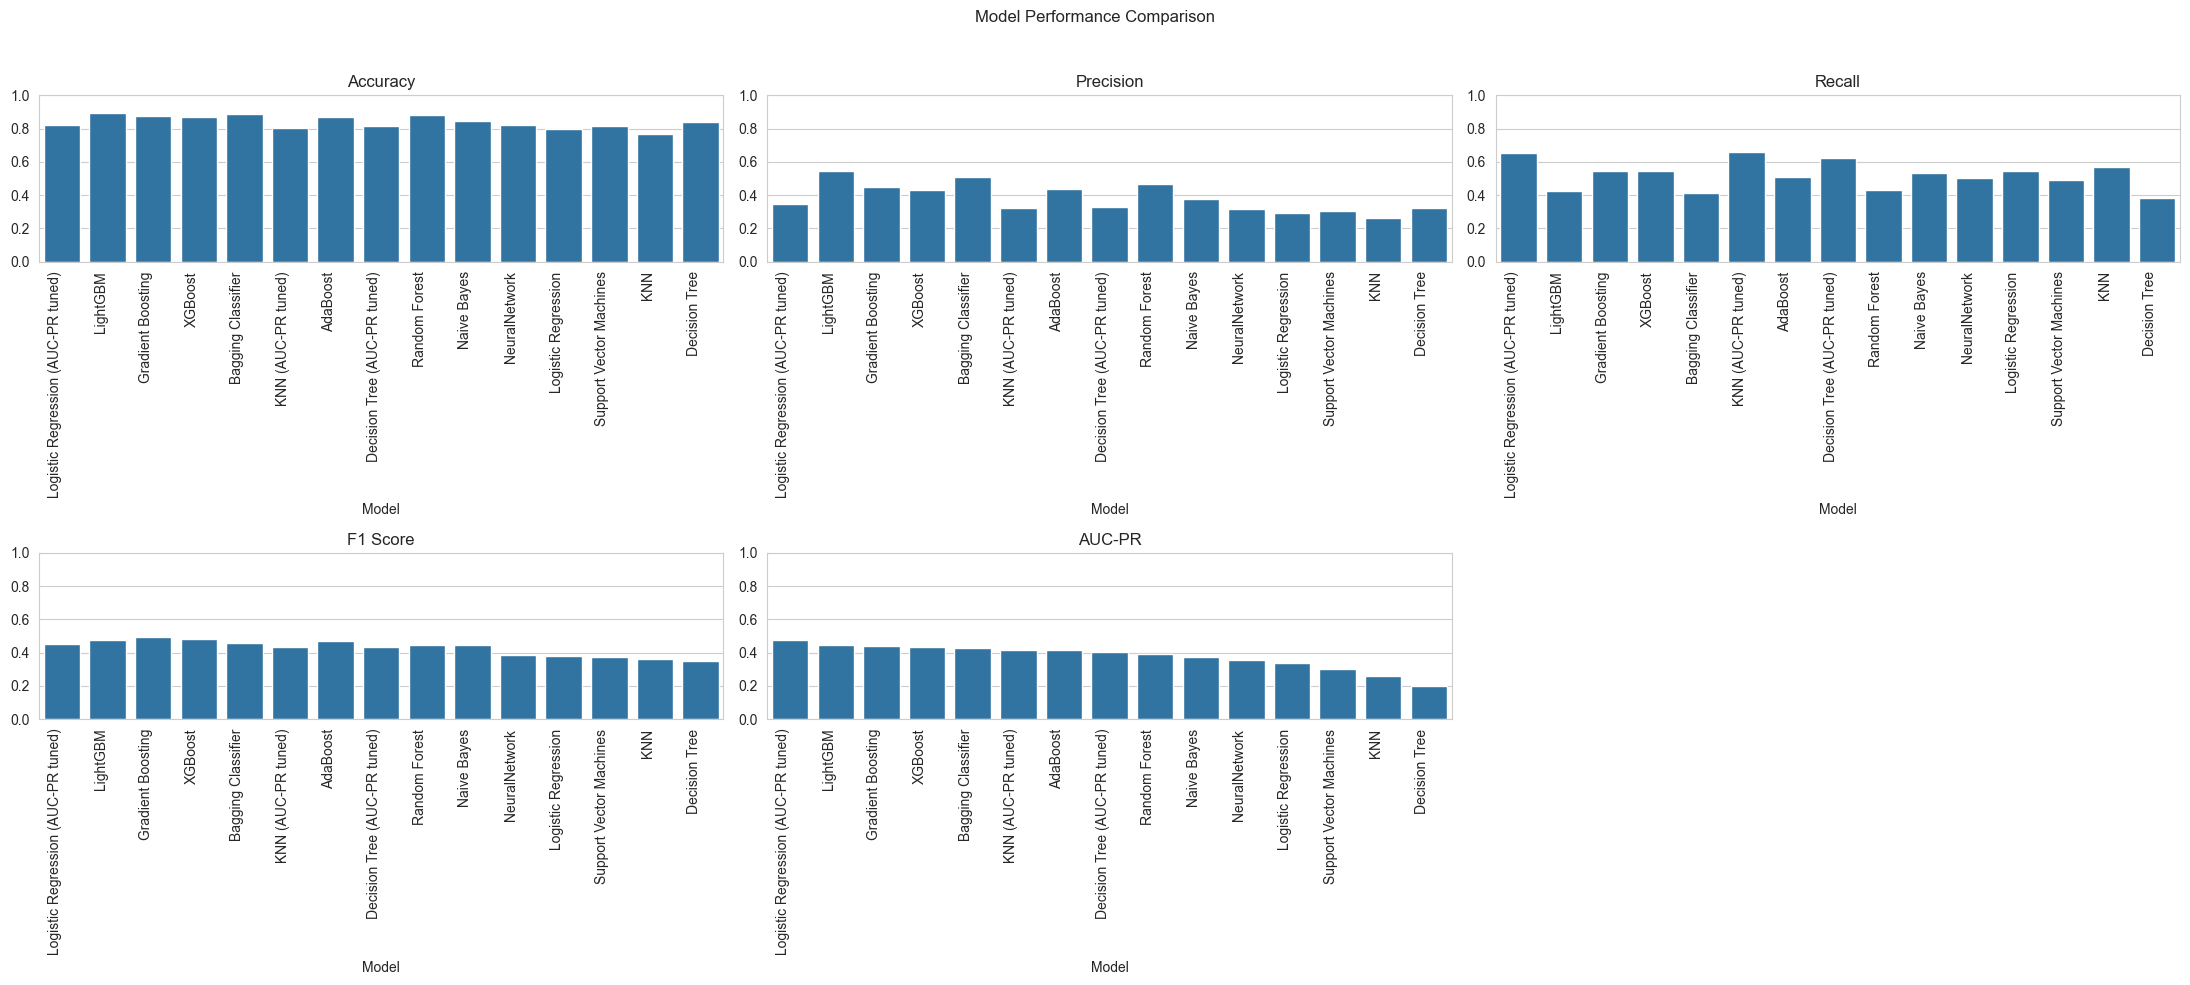

In [106]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-PR']

plt.figure(figsize=(22, 10))
plt.suptitle('Model Performance Comparison')
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=results_df, x='Model', y=metric)
    plt.title(metric)
    plt.ylabel('')
    plt.ylim(0, 1)
    plt.xticks(rotation=90, ha='right')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

---
## 6. Conclusions and Recommendations

### 6.1 Summary of Findings
This project successfully developed a machine learning model to predict which clients are likely to subscribe to a bank's term deposit, with the goal of improving the efficiency of telemarketing campaigns.

- Key Data Insights: The analysis began with a dataset characterized by a severe class imbalance, with only about 11% of clients subscribing to the deposit. This validated the choice of AUC-PR and Precision as the primary metrics for evaluation. Feature analysis consistently revealed that macroeconomic indicators (euribor3m, nr.employed) and direct campaign-related factors (campaign, poutcome) were the most significant predictors of success.

- Model Performance Journey: The modeling process progressed from simple baseline models to complex, tuned ensembles. While baseline models provided a reasonable starting point, the advanced gradient boosting methods (XGBoost and LightGBM) demonstrated clear superiority in their default states. However, after a thorough hyperparameter search, a well-tuned Logistic Regression model emerged as the most powerful. The Neural Network, despite extensive tuning, performed the poorest, suggesting that for this structured, tabular data, other architectures were more effective.

- Most Important Predictive Features: Across multiple models, the most influential features were consistently related to the prevailing economic climate, the outcome of previous campaigns, and the number of contacts made during the current campaign. This suggests that a client's decision is heavily influenced by both their personal history with the bank and broader economic conditions.

### 6.2 Best Model Selection
After a comprehensive evaluation, the tuned Logistic Regression model is identified as the most powerful and strategically valuable model for this project.

While the LightGBM model delivered the best out-of-the-box performance, the tuned Logistic Regression proved to have the highest potential and offered unique strategic advantages.

1. Highest Predictive Potential: The Logistic Regression model achieved the highest AUC-PR score of 0.475. This is the most critical metric for this imbalanced problem, as it indicates the model has the best underlying ability to balance precision and recall across all possible decision thresholds, making it fundamentally the most robust classifier.

2. High Interpretability: Unlike the "black box" nature of ensemble models, Logistic Regression's coefficients are directly interpretable. This provides invaluable business intelligence, clearly showing why a customer is considered a good lead (e.g., due to low interest rates or previous contact). This transparency builds trust and can inform marketing strategy beyond a simple prediction.

3. Excellent Recall: With a Recall of 66%, the model is highly effective at identifying the majority of potential buyers, ensuring fewer missed opportunities compared to other top models like LightGBM.

### 6.3 Future Work
To further enhance the project's value, the following steps could be explored:

- Threshold Tuning: The current precision is based on a default 0.5 probability threshold. By adjusting this threshold upwards (e.g., to 0.65), we could generate a smaller but even more precise list of "super-leads," further maximizing campaign efficiency for high-value targets.

- Feature Engineering: Explore the creation of more complex features, such as interaction terms between customer demographics and campaign details, to potentially uncover deeper insights.

### 6.4 Lessons Learned
- The Challenge of Imbalance: The project underscored the critical importance of addressing class imbalance. Relying on accuracy would have been highly misleading; focusing on AUC-PR and Precision from the start was key to finding a truly valuable model.

- The Power of Boosting: For this structured data problem, advanced gradient boosting algorithms proved to be the most effective tools, significantly outperforming both simpler models and the more complex Neural Network.

- Connecting Metrics to Business Goals: The most important lesson was the direct link between a business objective (cost-effective marketing) and the choice of a technical metric (Precision). This alignment ensured that the final model was not just technically proficient but also practically useful.

---

## Project Notes and Team Collaboration

### Team Members

- Julia Kardasz 1250264
- Mateusz Nowak 1250296
- Emilia Pawlowska 1250230